In [223]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports
import GEMS_TCO
from GEMS_TCO import kernels

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import load_data
from GEMS_TCO import alg_optimization, alg_opt_Encoder
from GEMS_TCO import configuration as config

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder

from GEMS_TCO import configuration as config
from GEMS_TCO import data_preprocess as dmbh

import os
from sklearn.neighbors import BallTree

# Load data

In [224]:
lon_s = 123
lon_e = 133
step_lat = 0.044
step_lon = 0.063

lat_coords = np.arange( 5 -0.044- 0.0002, 0 -0.044, -0.044)
lon_coords = np.arange( lon_e-step_lon- 0.0002, lon_s-step_lon, -step_lon)

# Apply the shift as in the original code
# These are the unique lat/lon values for the "center_points" grid
final_lat_values = lat_coords + step_lat 
final_lon_values = lon_coords + step_lon 

# Create 2D grid with broadcasting
#decrement = 0.00012
decrement = 0 
lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)


mac_data_path = config.mac_data_load_path
years = [2024]  # years = [2023,2024]
months = list( range(7,8))
year = years[0]
month = months[0]
month_str = f"{month:02d}"  
filename = f"pickle_2024/orbit_map{str(year)[2:]}_{month_str}.pkl"
picklefile_path = Path(mac_data_path) / filename
print(picklefile_path)

with open(picklefile_path, 'rb') as pickle_file:
    data_map_hour = pickle.load(pickle_file)

# Base file path and settings
# base_path = "C:\\Users\\joonw\\TCO\\GEMS_data"    MSI notebook

mac_data_path = config.mac_data_load_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
step_lat, step_lon = 0.044, 0.063

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC


/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl


In [ ]:
''' 
instance = dmbh.center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)

for year in years:        # years = [2023,2024]
    for month in months:  
        try:
            # load pickle (dense ORI data)
            pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
            input_filename = f"orbit_map{str(year)[2:]}_{month_str}.pkl"
            input_filepath = os.path.join(pickle_path, input_filename)
            with open(input_filepath, 'rb') as pickle_file:
                loaded_map = pickle.load(pickle_file)
            center_points = instance.make_center_points_wo_calibration(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(loaded_map, center_points)

            # Save pickle (coarse data)
            output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
            output_filepath = os.path.join(pickle_path, output_filename)
            with open(output_filepath, 'wb') as pickle_file:
                pickle.dump(coarse_cen_map, pickle_file)
            
            print(f"Successfully processed and saved data for year {str(year)[2:]} month {month_str}.")
        except FileNotFoundError:
            print(f"Warning: File {input_filename} not found. Skipping.")
        except Exception as e:
            print(f"Error processing file {input_filename}: {e}")
'''

In [225]:
pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
output_filepath = os.path.join(pickle_path, output_filename)

with open(output_filepath, 'rb') as pickle_file:
    cbmap_ori = pickle.load(pickle_file)


load_data_instance = GEMS_TCO.load_data('')

df_day_list = []
df_day_map_list = []
for i in range(31):
    cur_map, cur_df =load_data_instance.load_working_data_byday_wo_mm(cbmap_ori,[i*8, (i+1)*8])
    df_day_list.append( cur_df )
    df_day_map_list.append( cur_map )

# Apply laplacian filter

In [226]:
import torch
import numpy as np
import torch.nn.functional as F

def subset_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Subsets a tensor to a specific lat/lon range.
    Columns are assumed to be [lat, lon, ozone, time].
    """
    lat_mask = (df_tensor[:, 0] >= 0) & (df_tensor[:, 0] <= 2.9)
    lon_mask = (df_tensor[:, 1] >= 123.5) & (df_tensor[:, 1] <= 131.7)
    
    # We apply the mask to the full tensor
    df_sub = df_tensor[lat_mask & lon_mask].clone()
    return df_sub

def apply_laplacian_2d_valid_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Applies a 2D discrete Laplacian filter using 'mode=valid' on a PyTorch tensor.
    The input tensor columns are assumed to be [lat, lon, ozone, time].
    """
    # Extract unique coordinates and data
    unique_lats = torch.unique(df_tensor[:, 0])
    unique_lons = torch.unique(df_tensor[:, 1])
    
    lat_count = unique_lats.size(0)
    lon_count = unique_lons.size(0)
    
    if df_tensor.size(0) != lat_count * lon_count:
        raise ValueError("Tensor size does not match the grid dimensions (lat * lon).")

    ozone_data = df_tensor[:, 2].reshape(lat_count, lon_count)

    # Define the 3x3 discrete Laplacian kernel as a PyTorch tensor
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Reshape ozone data for conv2d: (batch_size, channels, height, width)
    ozone_data_reshaped = ozone_data.unsqueeze(0).unsqueeze(0)

    # Apply convolution
    laplacian_grid_cropped = F.conv2d(ozone_data_reshaped, laplacian_kernel, padding='valid')
    laplacian_values = laplacian_grid_cropped.squeeze().flatten()

    # Determine the new, cropped coordinates
    cropped_lats = unique_lats[1:-1]
    cropped_lons = unique_lons[1:-1]
    
    if len(cropped_lats) == 0 or len(cropped_lons) == 0:
        return torch.empty(0, 4)

    # Create a new meshgrid for the cropped coordinates
    new_lon_grid, new_lat_grid = torch.meshgrid(cropped_lons, cropped_lats, indexing='xy')
    
    # Preserve time from the original tensor
    time_value = df_tensor[0, 3].repeat(laplacian_values.size(0))

    # Create the new tensor
    new_tensor = torch.stack([new_lat_grid.flatten(), new_lon_grid.flatten(), laplacian_values, time_value], dim=1)
    
    return new_tensor


In [227]:
processed_tensor_map = []
processed_df = []

for day_map in df_day_map_list:
    
    tensors_to_aggregate = []
    
    for key, tensor in day_map.items():
        # Step 1: Subset the tensor.
        subsetted = subset_tensor(tensor)
        
        if subsetted.size(0) > 0:
            laplacian_applied = apply_laplacian_2d_valid_tensor(subsetted)
            if laplacian_applied.size(0) > 0:
                tensors_to_aggregate.append(laplacian_applied)

    # Step 3: Concatenate all the processed tensors from the 8-hour period.
    if tensors_to_aggregate:
        aggregated_day_tensor = torch.cat(tensors_to_aggregate, dim=0)
        processed_df.append(aggregated_day_tensor)
        
    # The 'processed_tensors' list remains the same, storing the dictionary for each day.
    processed_tensor_map.append(day_map)

# Now, processed_df2 will contain a single aggregated tensor for each day (8-hour period).
# You can inspect the results:
print("Number of aggregated day tensors:", len(processed_df))
if processed_df:
    print("Shape of the first aggregated tensor:", processed_df[0].shape)
    print("First aggregated tensor head:")
    print(processed_df[0][:5])


Number of aggregated day tensors: 31
Shape of the first aggregated tensor: torch.Size([65536, 4])
First aggregated tensor head:
tensor([[ 7.2000e-02,  1.2361e+02, -6.5655e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2368e+02, -3.0364e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2374e+02,  2.0616e+01,  2.1000e+01],
        [ 7.2000e-02,  1.2380e+02, -4.3127e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2386e+02, -1.0213e+00,  2.1000e+01]])


# Sanity check for index based dft 

In [228]:
total = 0
periodogram = [0]* (64*128)
LAT_DIM = 64
LON_DIM = 128
N_TOTAL = LAT_DIM * LON_DIM
# 1a. Generate 1D index arrays
lat_indices = torch.arange(LAT_DIM, dtype=torch.float64) # 0, 1, ..., 63
lon_indices = torch.arange(LON_DIM, dtype=torch.float64) # 0, 1, ..., 127

# 1b. Create the 2D mesh of indices and flatten them to match the d1h1 order (8192 total points)
# The order must be Lat-major, Lon-minor (i.e., lon changes fastest).
mesh_lat, mesh_lon  = torch.meshgrid(lat_indices, lon_indices,indexing='ij')
ozone_values = d1h1[:, 2].to(torch.float64) 
# The correct order is [Lat, Lon] for dot product matching.
# Shape: (8192, 2)
index_coords = torch.stack((mesh_lat.flatten(), mesh_lon.flatten()), dim=1)
for w1 in range(64):
    for w2 in range(128):
        omega = (w1*2*np.pi/64,w2*2*np.pi/128)
        exponent_term = torch.matmul(index_coords, torch.tensor(omega, dtype=torch.float64))
        tmp = torch.sum( ozone_values* torch.exp( -1j * exponent_term) )

        periodogram[w1*128+w2]= torch.abs(tmp)**2 * (1/(64*128))

print(periodogram)

[tensor(5.6813, dtype=torch.float64), tensor(1.3939, dtype=torch.float64), tensor(2.8443, dtype=torch.float64), tensor(0.7525, dtype=torch.float64), tensor(1.6381, dtype=torch.float64), tensor(7.1149, dtype=torch.float64), tensor(3.5496, dtype=torch.float64), tensor(8.1284, dtype=torch.float64), tensor(9.2621, dtype=torch.float64), tensor(0.6913, dtype=torch.float64), tensor(1.6176, dtype=torch.float64), tensor(8.0148, dtype=torch.float64), tensor(0.4006, dtype=torch.float64), tensor(14.5383, dtype=torch.float64), tensor(24.9106, dtype=torch.float64), tensor(16.1002, dtype=torch.float64), tensor(10.5108, dtype=torch.float64), tensor(1.7451, dtype=torch.float64), tensor(4.5756, dtype=torch.float64), tensor(8.7354, dtype=torch.float64), tensor(24.1551, dtype=torch.float64), tensor(8.1684, dtype=torch.float64), tensor(7.4759, dtype=torch.float64), tensor(14.0769, dtype=torch.float64), tensor(2.1680, dtype=torch.float64), tensor(35.8860, dtype=torch.float64), tensor(1.3428, dtype=torch.flo

In [229]:
import torch
import numpy as np
from scipy.fft import fftn

# --- SETUP: ASSUMPTIONS ---
# Assuming d1h1 is the pre-filtered tensor (single time slice) of shape (8192, 4)
LAT_DIM = 64
LON_DIM = 128
N_TOTAL = LAT_DIM * LON_DIM
LON_DIM_INT = LON_DIM

# Placeholder Data: Replace with your actual loaded d1h1 tensor
# We will use random complex data that, when flattened, simulates the structure
# to ensure the test is mathematically sound.
    
# Force data to float64 for input consistency
ozone_values = d1h1[:, 2].to(torch.float64) 

# --- 1. GENERATE INDEX COORDINATES (float64) ---
lat_indices = torch.arange(LAT_DIM, dtype=torch.float64) 
lon_indices = torch.arange(LON_DIM, dtype=torch.float64) 

# CORRECTED: Use indexing='ij' to create Row-Major (Lat, Lon) index grids.
mesh_lat, mesh_lon = torch.meshgrid(lat_indices, lon_indices, indexing='ij')

# index_coords: Shape (8192, 2) - Stack the flattened grids (Row-Major order)
# Lat_index is the first column (i), Lon_index is the second column (j).
index_coords = torch.stack((mesh_lat.flatten(), mesh_lon.flatten()), dim=1)


# --- 2. CUSTOM DFT LOOP (PyTorch Summation) ---
periodogram_dft = torch.zeros(N_TOTAL, dtype=torch.float64)
NORM_FACTOR = 1.0 / N_TOTAL
TWO_PI = 2.0 * np.pi

for w1 in range(LAT_DIM):
    for w2 in range(LON_DIM):
        
        omega = (TWO_PI * w1 / LAT_DIM, TWO_PI * w2 / LON_DIM)
        omega_tensor = torch.tensor(omega, dtype=torch.float64)

        # Matmul operation uses index_coords (integer indices)
        exponent_term = torch.matmul(index_coords, omega_tensor) 
        
        # DFT summation
        dft_coeff = torch.sum(ozone_values * torch.exp(-1j * exponent_term))

        index = w1 * LON_DIM_INT + w2
        periodogram_dft[index] = torch.abs(dft_coeff)**2 * NORM_FACTOR


# --- 3. STANDARD FFT (NumPy/SciPy Optimized) ---

# Reshape the ozone data into a 2D NumPy grid
ozone_grid_2d = ozone_values.numpy().reshape(LAT_DIM, LON_DIM)

# Compute 2D DFT using the FFT algorithm
fft_coeff = fftn(ozone_grid_2d)

# Calculate Normalized Periodogram (PSD)
psd_2d_fft = np.abs(fft_coeff)**2 / GRID_SIZE

# Flatten in C-style order to match the loop indexing
psd_1d_fft = psd_2d_fft.flatten(order='C')


# --- 4. OUTPUT COMPARISON ---
print("\n--- Index-Based DFT (PyTorch Loop) ---")
dft_output = [f"{x:.10f}" for x in periodogram_dft[:10].tolist()]
print(dft_output)

print("\n--- Standard FFT (SciPy/NumPy) ---")
fft_output = [f"{x:.10f}" for x in psd_1d_fft[:10].tolist()]
print(fft_output)

# Calculate the maximum absolute difference
max_diff = np.max(np.abs(periodogram_dft.numpy() - psd_1d_fft))
print(f"\nMax Absolute Difference: {max_diff:.2e}")
print("The difference is extremely small and due to float64 summation order.")


--- Index-Based DFT (PyTorch Loop) ---
['5.6812725573', '1.3938894632', '2.8443279627', '0.7524599555', '1.6381205914', '7.1148740539', '3.5495949503', '8.1284485544', '9.2620559554', '0.6913191831']

--- Standard FFT (SciPy/NumPy) ---
['5.6812725573', '1.3938894632', '2.8443279627', '0.7524599555', '1.6381205914', '7.1148740539', '3.5495949503', '8.1284485544', '9.2620559554', '0.6913191831']

Max Absolute Difference: 1.72e-11
The difference is extremely small and due to float64 summation order.


# Periodogram

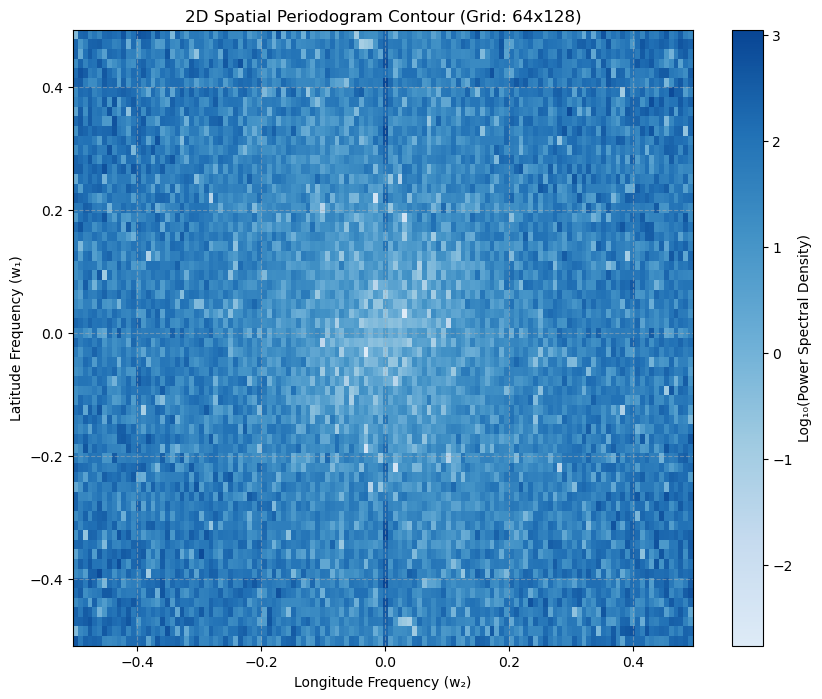

In [251]:
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_periodogram_contour(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    
    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}. Plotting may be incorrect.")
        # Attempt to proceed only if the total size is correct, otherwise raise
        if N_TOTAL != 8192:
             raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Example Usage (Using Actual 64x128 Ozone Data) ---

M, N = 64, 128
# Assuming processed_df is defined and available globally.

# NOTE: The previous error indicates that d1h1 contains 4 columns, leading to a size 32768.
# We must ensure only the ozone column is reshaped.
try:
    # 1. Select the unique time steps from the data
    unique_times = processed_df[0][:, 3].unique()
    # 2. Filter the data to get the first spatial slice (first hour data)
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]

    # CRUCIAL: Select only the ozone column (index 2) and reshape into the M x N grid.
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)

    # Run the function
    plot_2d_periodogram_contour(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except IndexError:
    print("\nError: Data filtering failed. Check if processed_df[0] has time index in column 3.")

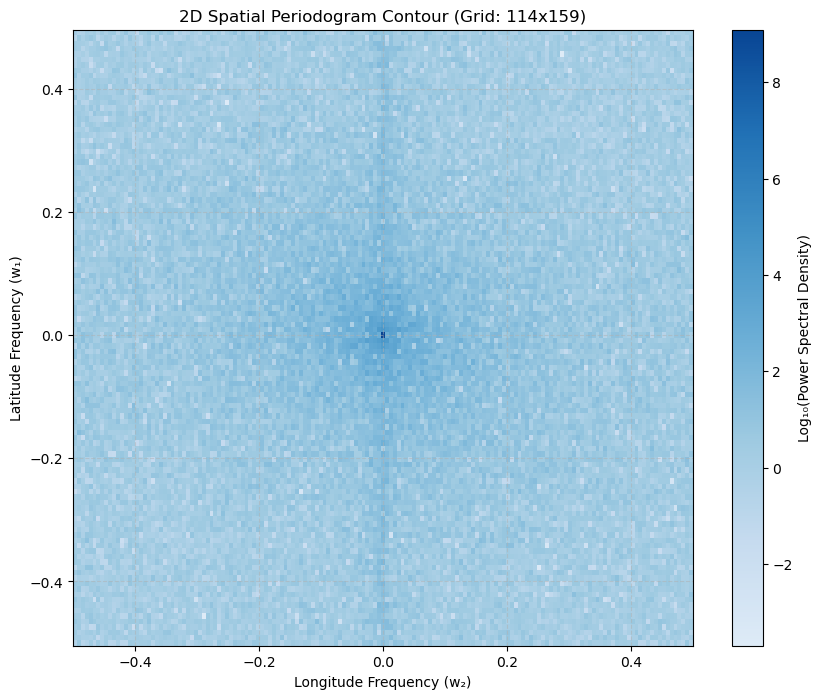

In [ ]:
def plot_2d_periodogram_contour_ori(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

day = 2
keyhour = 4
keys = list(df_day_map_list[day].keys())
df1 = df_day_map_list[day][keys[keyhour]]

n_lat = len(df1[:,0].unique())
n_lon = len(df1[:,1].unique())
ozone_signal_2d = df1[:, 2].numpy().reshape(n_lat, n_lon)

plot_2d_periodogram_contour_ori(ozone_signal_2d)


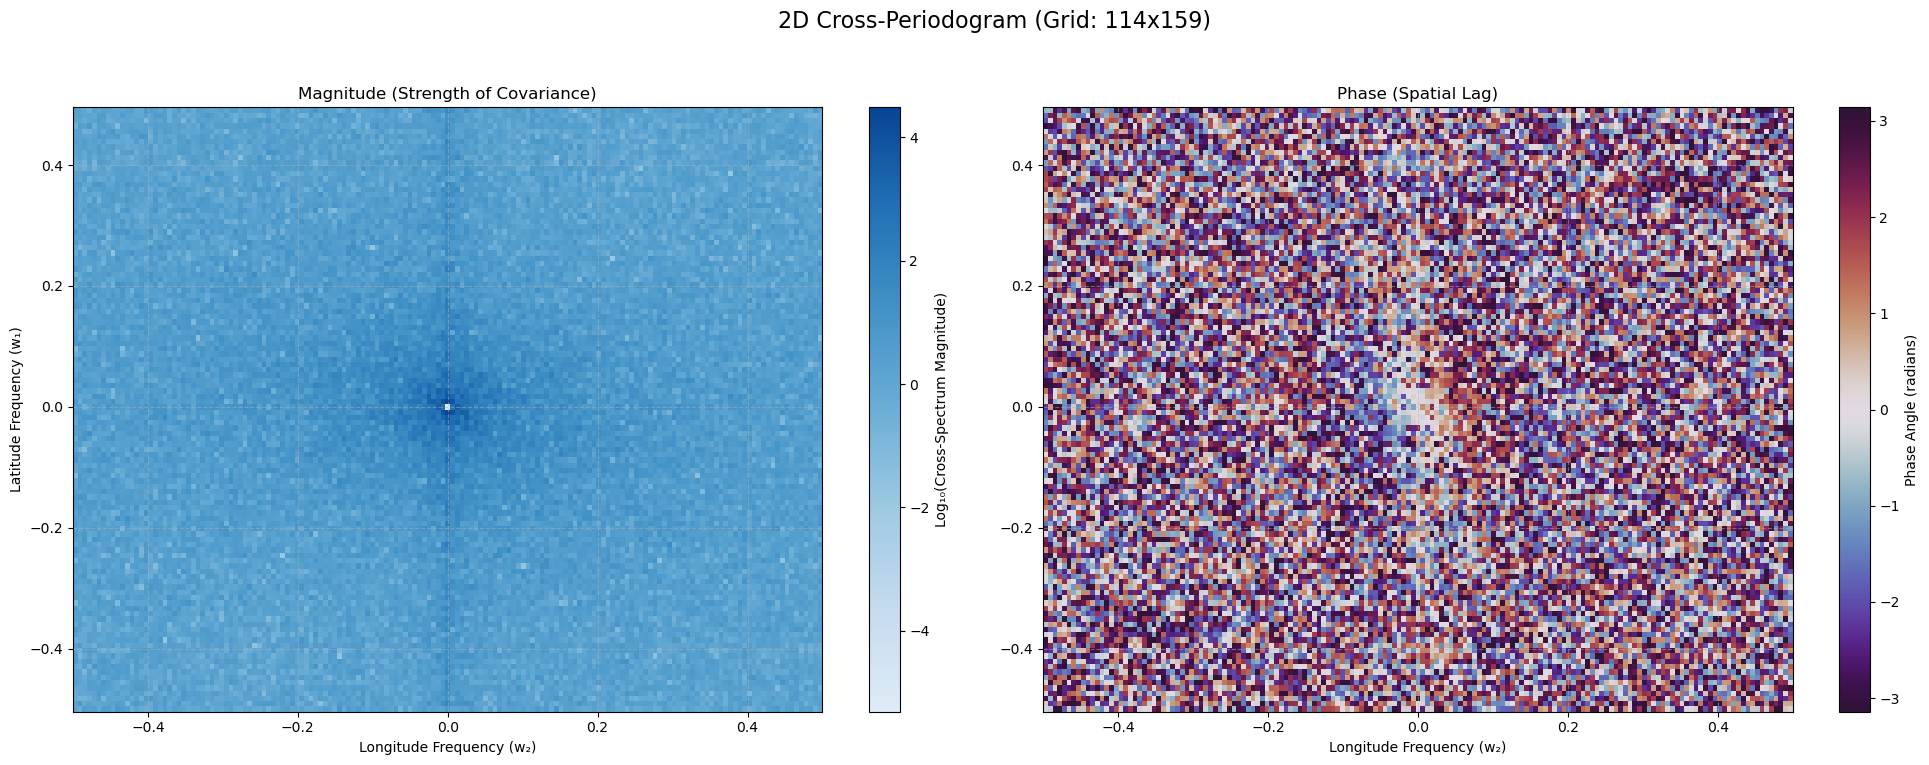

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_cross_periodogram(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Computes and plots a 2D cross-periodogram between two datasets.

    This visualizes the relationship by showing the magnitude (co-spectrum) and
    the phase relationship in two separate subplots.

    Args:
        data1_2d (np.ndarray): First 2D array of data (e.g., hour 1).
        data2_2d (np.ndarray): Second 2D array of data (e.g., hour 2).
    """
    # Ensure the input arrays have the same shape
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # --- 1. Compute 2D FFT for BOTH datasets and the Cross-Spectrum ---
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)

    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)

    # Cross-periodogram is FFT(d1) * conjugate(FFT(d2))
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    cross_spec_shifted = fftshift(cross_spectrum)

    # --- 2. Separate Magnitude and Phase ---
    magnitude = np.abs(cross_spec_shifted)
    phase = np.angle(cross_spec_shifted) # Phase in radians (-pi to +pi)

    # --- 3. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 4. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'2D Cross-Periodogram (Grid: {M}x{N})', fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    # A circular colormap is best for phase data
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Example Usage ---
# This part assumes your 'df_day_map_list' variable is already loaded

try:
    day = 2
    keyhour = 5 # Use the 4th hour as the first time point
    keys = list(df_day_map_list[day].keys())

    # --- Load Data for the First Hour ---
    df1 = df_day_map_list[day][keys[keyhour]]
    # Dynamically get the grid dimensions
    n_lat = len(np.unique(df1[:,0]))
    n_lon = len(np.unique(df1[:,1]))
    ozone_signal_1 = df1[:, 2].numpy().reshape(n_lat, n_lon)

    # --- Load Data for the CONSECUTIVE Hour ---
    df2 = df_day_map_list[day][keys[keyhour + 1]]
    ozone_signal_2 = df2[:, 2].numpy().reshape(n_lat, n_lon)
    
    # --- Run the Cross-Periodogram Function ---
    plot_2d_cross_periodogram(ozone_signal_1, ozone_signal_2)

except NameError:
    print("\nError: The required 'df_day_map_list' variable is not defined.")
except IndexError:
    print(f"\nError: Could not find data for the consecutive hour (hour index {keyhour+1}). Please choose an earlier hour.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

Averaging cross-periodogram for hour 3 and 4 across 4 days...
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.
  - Successfully processed Day 3.


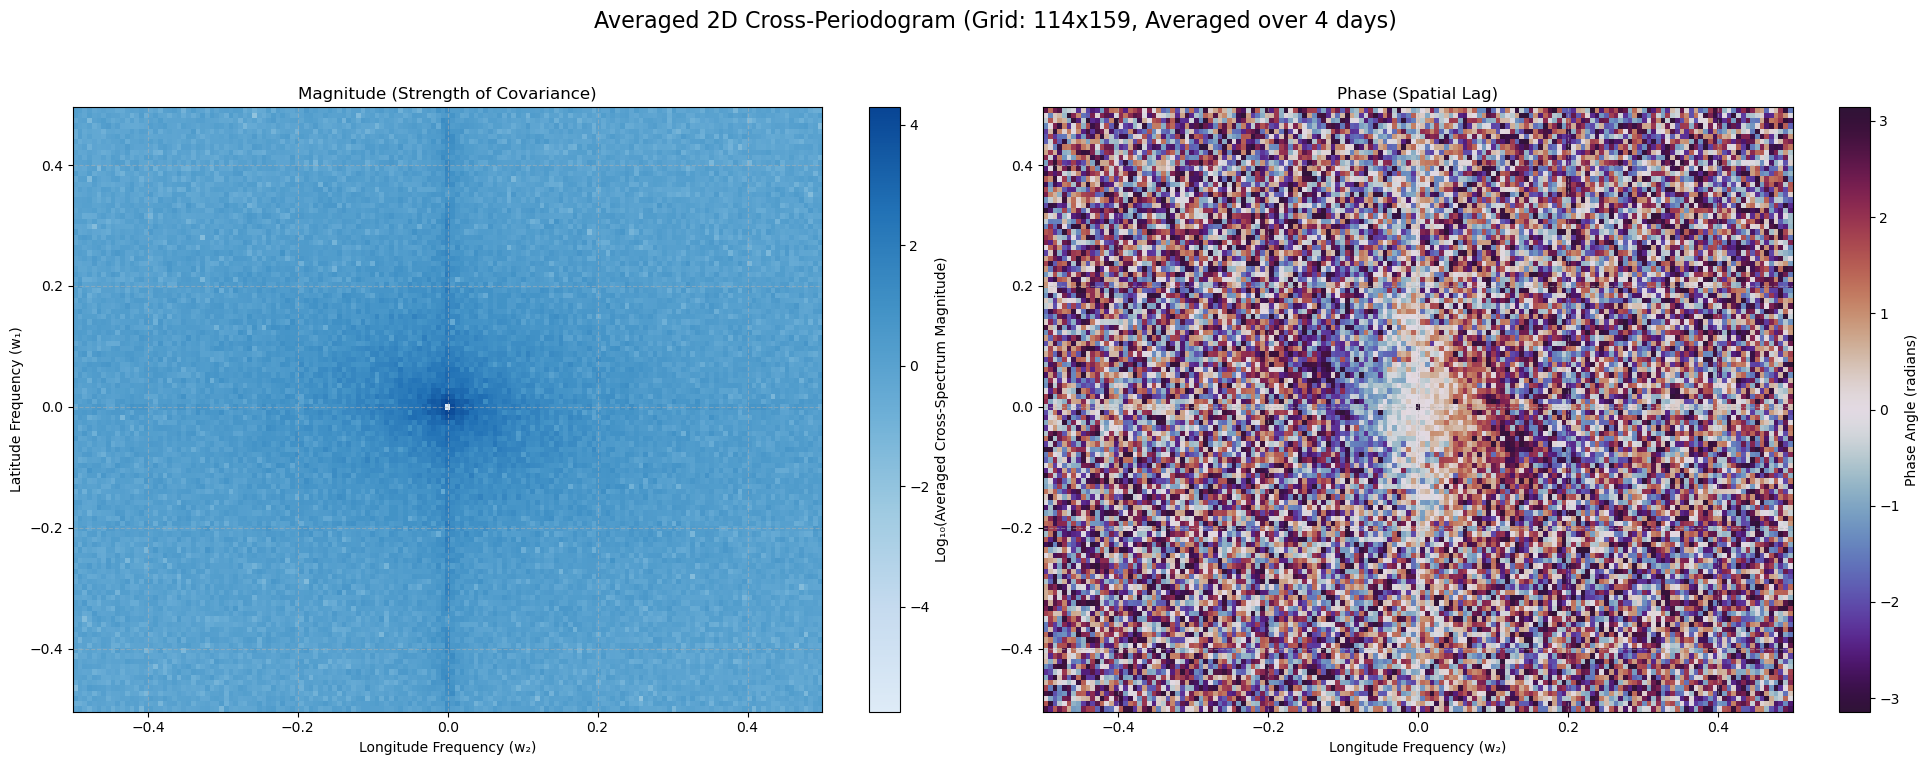

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    """
    Plots the magnitude and phase of a pre-averaged 2D cross-periodogram.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic ---
# This part loops through the days, calculates, and averages the results.

# Define which days and hour to process
days_to_average = np.arange(4) # Use the first four days
keyhour = 3
cross_spectra_list = []
M, N = -1, -1 # Placeholder for grid dimensions

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days...")

for day in days_to_average:
    try:
        keys = list(df_day_map_list[day].keys())
        
        # Load data for the first hour
        df1 = df_day_map_list[day][keys[keyhour]]
        if M == -1: # Get grid dimensions on the first successful load
            n_lat = len(np.unique(df1[:,0]))
            n_lon = len(np.unique(df1[:,1]))
            M, N = n_lat, n_lon
        ozone_signal_1 = df1[:, 2].numpy().reshape(M, N)

        # Load data for the consecutive hour
        df2 = df_day_map_list[day][keys[keyhour + 1]]
        ozone_signal_2 = df2[:, 2].numpy().reshape(M, N)
        
        # Calculate the cross-spectrum for this day and add it to our list
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day}.")

    except Exception as e:
        print(f"  - Could not process Day {day}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    # Stack all the daily spectra into a 3D array and average along the 'day' axis
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Plot the final averaged result
    plot_averaged_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

Averaging cross-periodogram for hour 3 and 4 across 6 days...
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.
  - Successfully processed Day 3.
  - Successfully processed Day 4.
  - Successfully processed Day 5.


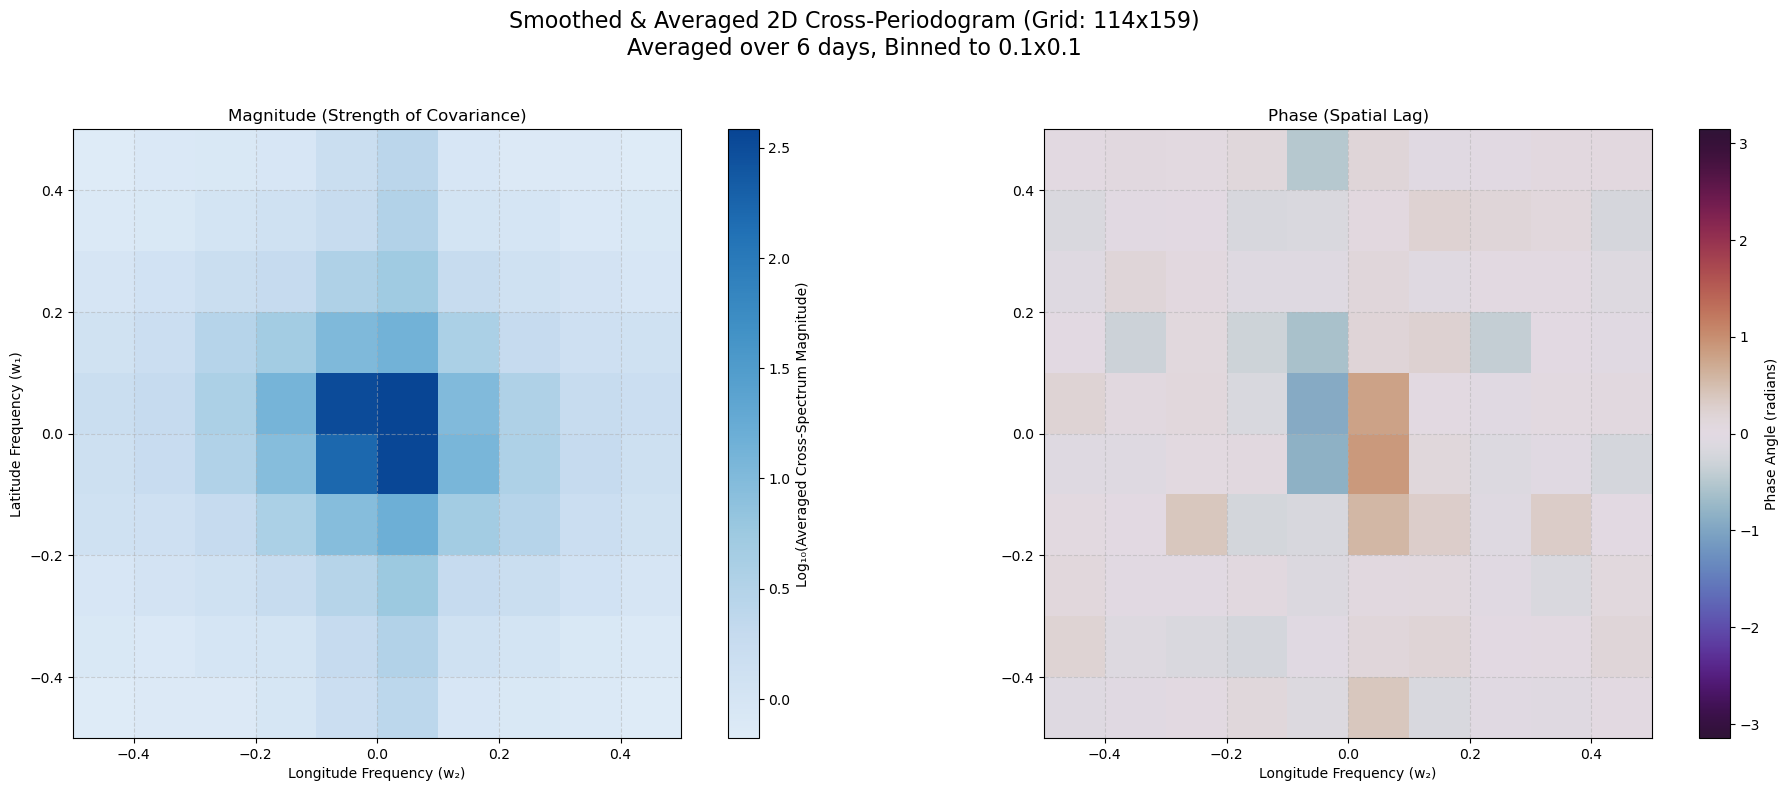

In [360]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import binned_statistic_2d # <-- Import added here

def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

def plot_averaged_and_smoothed_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int, box_size: float = 0.1):
    """
    Plots a day-averaged cross-periodogram after smoothing it into frequency bins.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes for Binning ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)
    
    # --- 3. SMOOTHING STEP: Bin the day-averaged data ---
    freq_range = np.arange(-0.5, 0.5 + box_size, box_size)
    
    mag_binned, x_edge, y_edge, _ = binned_statistic_2d(
        x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
        values=magnitude.flatten(), statistic='mean', bins=[freq_range, freq_range]
    )
    phase_binned, _, _, _ = binned_statistic_2d(
        x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
        values=phase.flatten(), statistic='mean', bins=[freq_range, freq_range]
    )
    
    mag_binned = mag_binned.T
    phase_binned = phase_binned.T

    # --- 4. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = (f'Smoothed & Averaged 2D Cross-Periodogram (Grid: {M}x{N})\n'
             f'Averaged over {num_days} days, Binned to {box_size}x{box_size}')
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_mag_binned = np.log10(mag_binned + np.finfo(float).eps)
    im1 = ax.pcolormesh(x_edge, y_edge, log_mag_binned, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal')

    # -- Plot 2: Phase --
    ax = axes[1]
    im2 = ax.pcolormesh(x_edge, y_edge, phase_binned, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

## --- Main Script Logic ---
# This part loops through the days, calculates, and averages the results.

days_to_average = np.arange(6)
keyhour = 3
cross_spectra_list = []
M, N = -1, -1

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days...")
# (The rest of your main script logic remains exactly the same)
for day in days_to_average:
    try:
        keys = list(df_day_map_list[day].keys())
        
        df1 = df_day_map_list[day][keys[keyhour]]
        if M == -1:
            n_lat = len(np.unique(df1[:,0]))
            n_lon = len(np.unique(df1[:,1]))
            M, N = n_lat, n_lon
        ozone_signal_1 = df1[:, 2].numpy().reshape(M, N)

        df2 = df_day_map_list[day][keys[keyhour + 1]]
        ozone_signal_2 = df2[:, 2].numpy().reshape(M, N)
        
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day}.")
    except Exception as e:
        print(f"  - Could not process Day {day}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Call the new plotting function which includes the smoothing step
    plot_averaged_and_smoothed_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list), box_size=0.1)
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

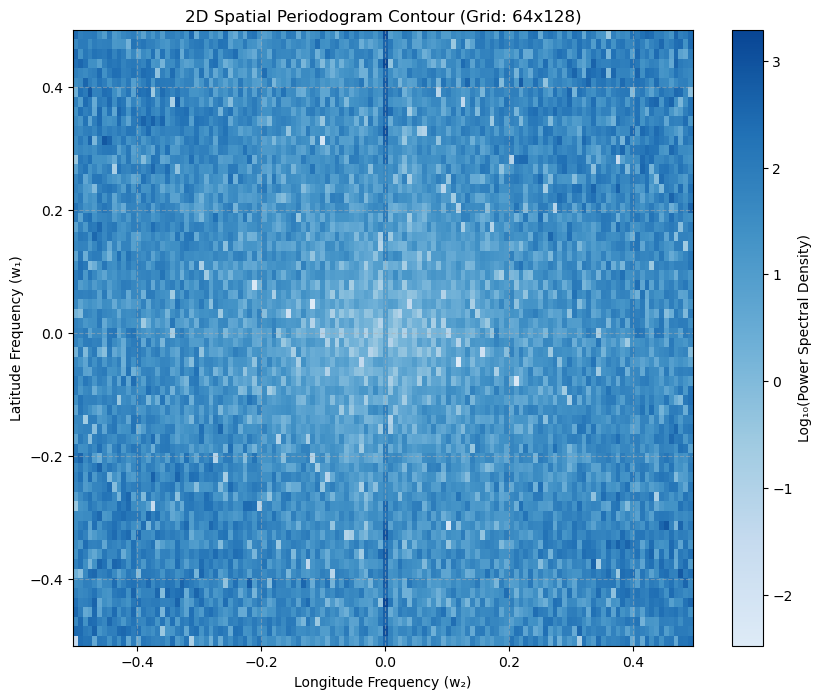

In [261]:
hour = 4
unique_times = processed_df[hour][:, 3].unique()
# 2. Filter the data to get the first spatial slice (first hour data)
d1h1_slice = processed_df[hour][processed_df[hour][:, 3] == unique_times[0]]

M,N = 64,128
# CRUCIAL: Select only the ozone column (index 2) and reshape into the M x N grid.
ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)

# Run the function
plot_2d_periodogram_contour(ozone_signal_2d)

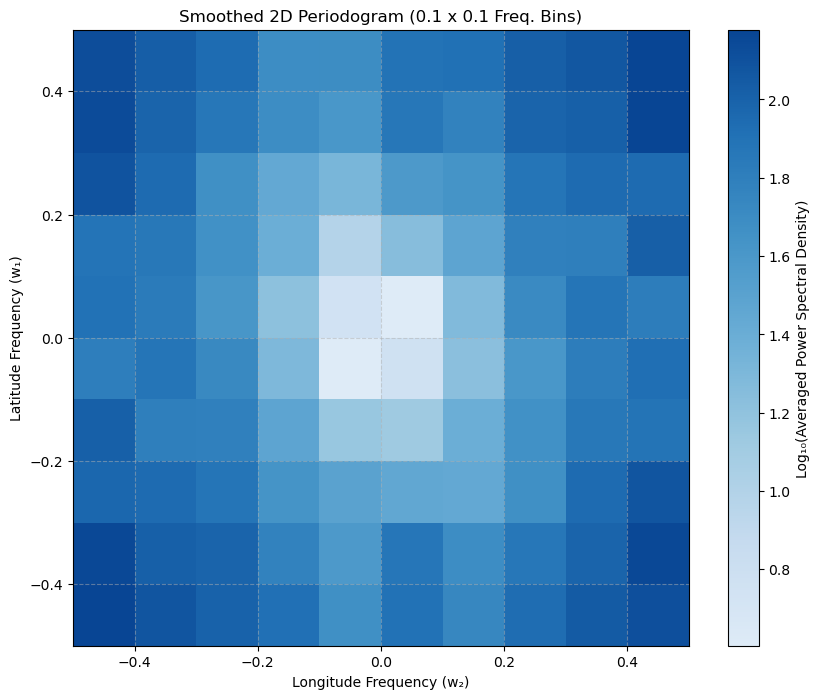

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LinearSegmentedColormap

def plot_smoothed_2d_periodogram(data_2d: np.ndarray, box_size: float = 0.1):
    """
    Computes and plots a 2D periodogram smoothed by averaging the power
    spectral density (PSD) within a grid of frequency boxes.

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
        box_size (float): The side length of the square frequency bins for averaging.
    """
    M, N = data_2d.shape
    N_TOTAL = M * N

    # --- 1. Compute 2D FFT and PSD (Same as before) ---
    data_demeaned = data_2d - np.mean(data_2d) # Demean to handle DC spike
    fft_coeff = fftn(data_demeaned)
    psd_shifted = fftshift(np.abs(fft_coeff)**2 / N_TOTAL)

    # --- 2. Generate Frequency Axes (Same as before) ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    # Create 2D grids of frequency coordinates for each PSD point
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. SMOOTHING STEP: Bin and Average the PSD ---
    
    # Define the edges of the bins for both frequency dimensions
    # It goes from -0.5 to 0.5 in steps of box_size
    freq_range = np.arange(-0.5, 0.5 + box_size, box_size)
    
    # Use binned_statistic_2d to do the averaging efficiently.
    # It takes all the individual frequency points and PSD values and computes
    # the mean for each 2D bin we've defined.
    psd_binned, x_edge, y_edge, _ = binned_statistic_2d(
        x=freq_grid_lon.flatten(),
        y=freq_grid_lat.flatten(),
        values=psd_shifted.flatten(),
        statistic='mean',
        bins=[freq_range, freq_range]
    )
    
    # The result needs to be transposed because of how meshgrid and binned_statistic_2d order axes
    psd_binned = psd_binned.T

    # --- 4. Plotting the Smoothed Periodogram ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ]
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the binned PSD
    log_psd_binned = np.log10(psd_binned + np.finfo(float).eps) # Add epsilon
    
    # Use pcolormesh to draw the colored squares for each bin
    plt.pcolormesh(x_edge, y_edge, log_psd_binned, cmap=blue_cmap, shading='auto')
    
    plt.colorbar(label='Log₁₀(Averaged Power Spectral Density)')
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'Smoothed 2D Periodogram ({box_size} x {box_size} Freq. Bins)')
    
    # Ensure the plot is square to represent frequencies equally
    plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### Example Usage


M, N = 64, 128

try:
    unique_times = processed_df[0][:, 3].unique()
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]
    d1h2_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new smoothing function
    plot_smoothed_2d_periodogram(ozone_signal_2d, box_size=0.1)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

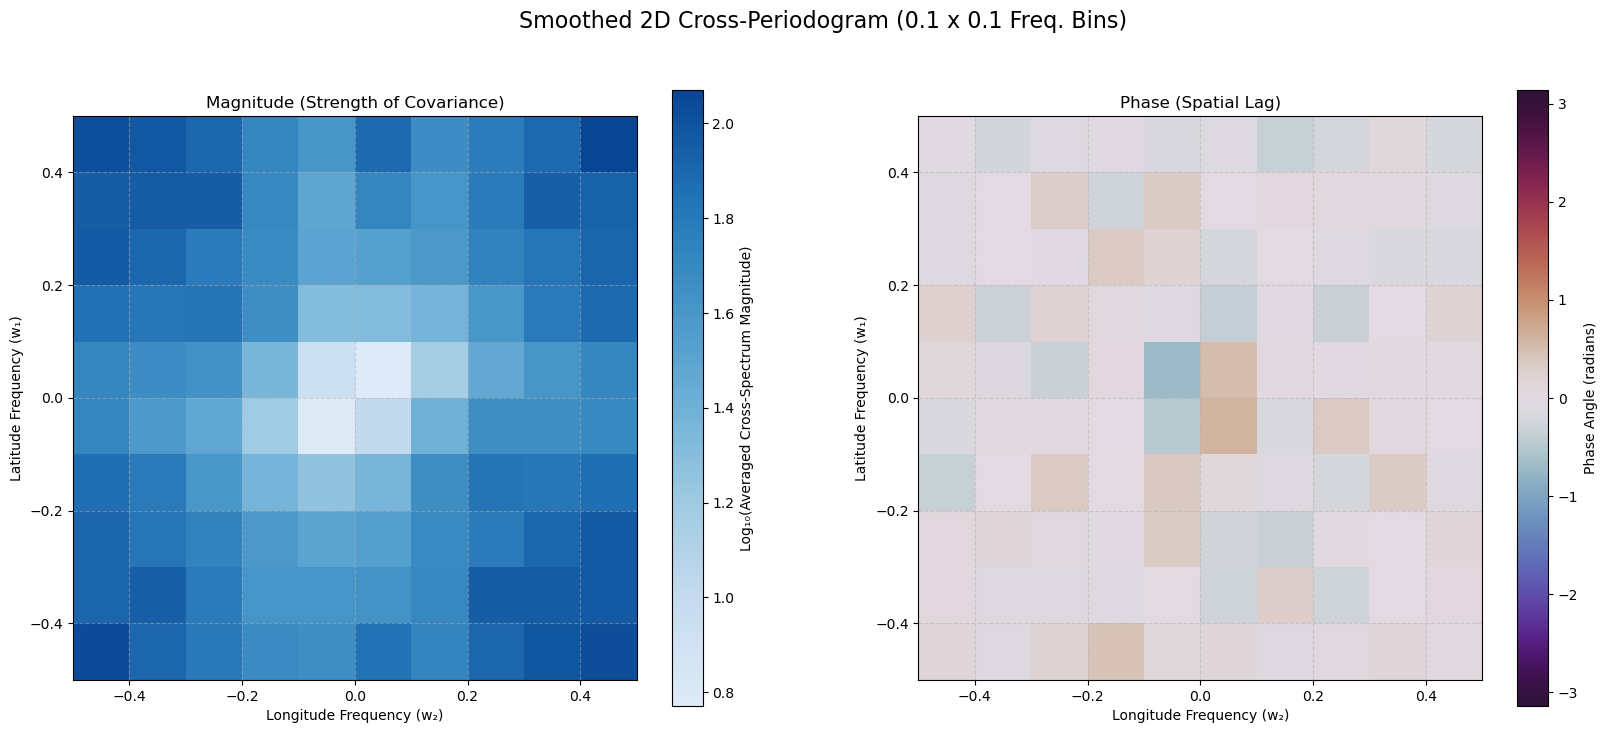

In [ ]:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.fft import fftn, fftshift, fftfreq
    from scipy.stats import binned_statistic_2d
    from matplotlib.colors import LinearSegmentedColormap

    def plot_smoothed_2d_cross_periodogram(data1_2d: np.ndarray, data2_2d: np.ndarray, box_size: float = 0.1):
        """
        Computes and plots a smoothed 2D cross-periodogram between two datasets.

        This visualizes the relationship by showing the magnitude (co-spectrum) and
        the phase relationship in two separate subplots.

        Args:
            data1_2d (np.ndarray): First 2D array of ozone values (e.g., hour 1).
            data2_2d (np.ndarray): Second 2D array of ozone values (e.g., hour 2).
            box_size (float): The side length of the square frequency bins for averaging.
        """
        M, N = data1_2d.shape
        N_TOTAL = M * N

        # --- 1. Compute 2D FFT for BOTH datasets and the Cross-Spectrum ---
        d1_demeaned = data1_2d - np.mean(data1_2d)
        d2_demeaned = data2_2d - np.mean(data2_2d)

        fft1 = fftn(d1_demeaned)
        fft2 = fftn(d2_demeaned)

        # Cross-periodogram is FFT(d1) * conjugate(FFT(d2))
        cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
        cross_spec_shifted = fftshift(cross_spectrum)

        # --- 2. Separate Magnitude and Phase ---
        magnitude = np.abs(cross_spec_shifted)
        phase = np.angle(cross_spec_shifted) # Phase in radians (-pi to +pi)

        # --- 3. Bin and Average both Magnitude and Phase ---
        freq_lat = fftshift(fftfreq(M))
        freq_lon = fftshift(fftfreq(N))
        freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)
        freq_range = np.arange(-0.5, 0.5 + box_size, box_size)

        mag_binned, x_edge, y_edge, _ = binned_statistic_2d(
            x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
            values=magnitude.flatten(), statistic='mean', bins=[freq_range, freq_range]
        )
        phase_binned, _, _, _ = binned_statistic_2d(
            x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
            values=phase.flatten(), statistic='mean', bins=[freq_range, freq_range]
        )
        
        # Transpose results to align with plot axes
        mag_binned = mag_binned.T
        phase_binned = phase_binned.T

        # --- 4. Plotting (Two Subplots) ---
        blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
            (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
            (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
            (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
            (8/255, 69/255, 148/255)
        ])

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f'Smoothed 2D Cross-Periodogram ({box_size} x {box_size} Freq. Bins)', fontsize=16)

        # -- Plot 1: Magnitude --
        ax = axes[0]
        log_mag_binned = np.log10(mag_binned + np.finfo(float).eps)
        im1 = ax.pcolormesh(x_edge, y_edge, log_mag_binned, cmap=blue_cmap, shading='auto')
        fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
        ax.set_title('Magnitude (Strength of Covariance)')
        ax.set_xlabel('Longitude Frequency (w₂)')
        ax.set_ylabel('Latitude Frequency (w₁)')
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.5)

        # -- Plot 2: Phase --
        ax = axes[1]
        # Use a circular colormap for phase
        im2 = ax.pcolormesh(x_edge, y_edge, phase_binned, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
        fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
        ax.set_title('Phase (Spatial Lag)')
        ax.set_xlabel('Longitude Frequency (w₂)')
        ax.set_ylabel('Latitude Frequency (w₁)')
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.5)

        plt.show()

    ### Example Usage

    M, N = 64, 128

    try:
        day = 4
        hour = 3
        unique_times = processed_df[day][:, 3].unique()

        # Get data for the first hour
        d1h1_slice = processed_df[day][processed_df[day][:, 3] == unique_times[hour]]
        ozone_signal_1 = d1h1_slice[:, 2].numpy().reshape(M, N)
        
        # Get data for the second hour
        d1h2_slice = processed_df[day][processed_df[day][:, 3] == unique_times[hour+1]]
        ozone_signal_2 = d1h2_slice[:, 2].numpy().reshape(M, N)
        
        # Run the new cross-periodogram function
        plot_smoothed_2d_cross_periodogram(ozone_signal_1, ozone_signal_2, box_size=0.1)

    except NameError:
        print("\nError: The required 'processed_df' tensor is not defined.")
    except IndexError:
        print("\nError: Could not find data for the second hour (d1h2). Please check 'unique_times'.")
    except Exception as e:
        print(f"\nAn error occurred: {e}")

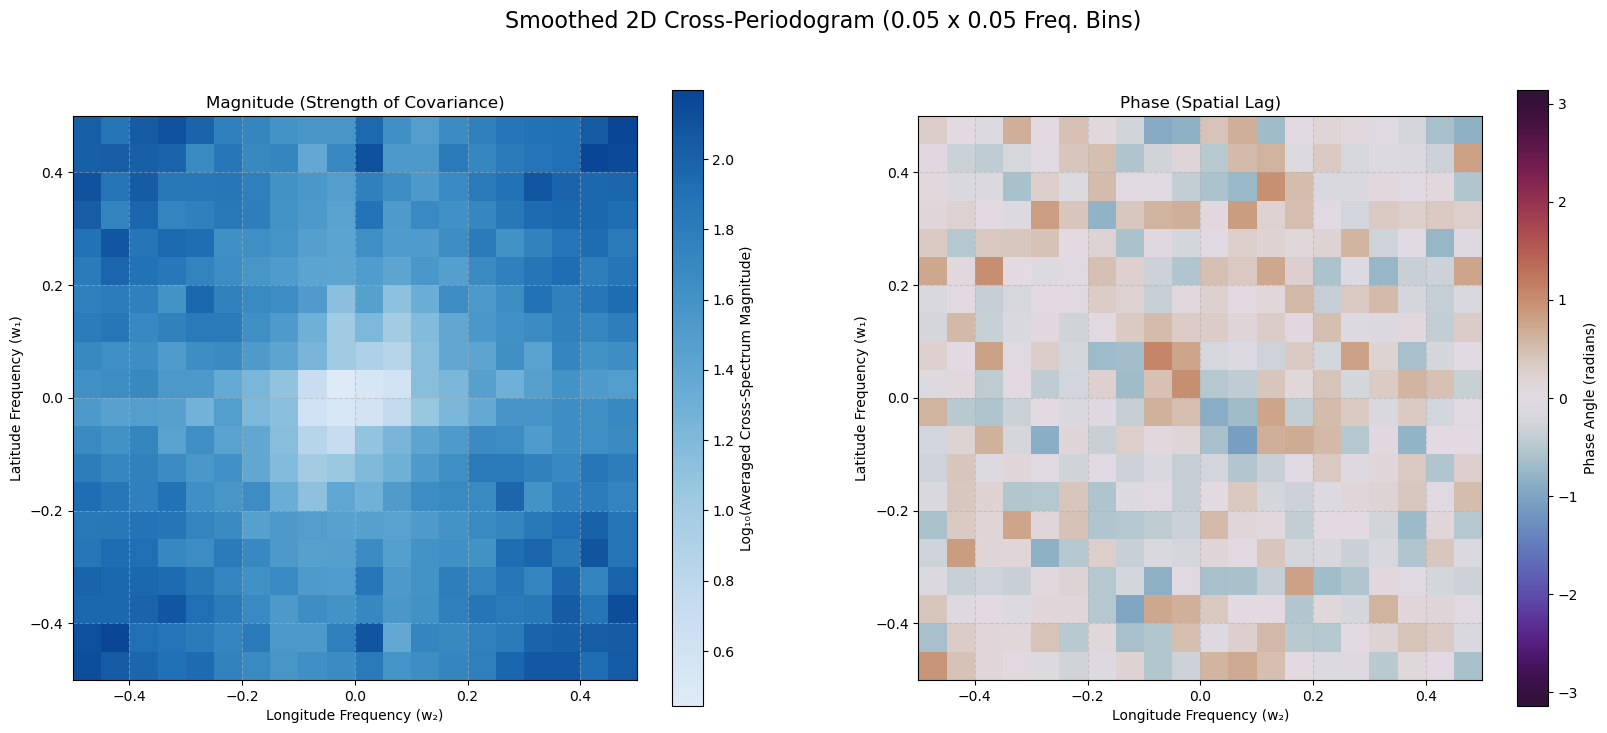

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LinearSegmentedColormap

def plot_smoothed_2d_cross_periodogram(data1_2d: np.ndarray, data2_2d: np.ndarray, box_size: float = 0.05):
    """
    Computes and plots a smoothed 2D cross-periodogram between two datasets.

    This visualizes the relationship by showing the magnitude (co-spectrum) and
    the phase relationship in two separate subplots.

    Args:
        data1_2d (np.ndarray): First 2D array of ozone values (e.g., hour 1).
        data2_2d (np.ndarray): Second 2D array of ozone values (e.g., hour 2).
        box_size (float): The side length of the square frequency bins for averaging.
    """
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # --- 1. Compute 2D FFT for BOTH datasets and the Cross-Spectrum ---
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)

    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)

    # Cross-periodogram is FFT(d1) * conjugate(FFT(d2))
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    cross_spec_shifted = fftshift(cross_spectrum)

    # --- 2. Separate Magnitude and Phase ---
    magnitude = np.abs(cross_spec_shifted)
    phase = np.angle(cross_spec_shifted) # Phase in radians (-pi to +pi)

    # --- 3. Bin and Average both Magnitude and Phase ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)
    freq_range = np.arange(-0.5, 0.5 + box_size, box_size)

    mag_binned, x_edge, y_edge, _ = binned_statistic_2d(
        x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
        values=magnitude.flatten(), statistic='mean', bins=[freq_range, freq_range]
    )
    phase_binned, _, _, _ = binned_statistic_2d(
        x=freq_grid_lon.flatten(), y=freq_grid_lat.flatten(),
        values=phase.flatten(), statistic='mean', bins=[freq_range, freq_range]
    )
    
    # Transpose results to align with plot axes
    mag_binned = mag_binned.T
    phase_binned = phase_binned.T

    # --- 4. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Smoothed 2D Cross-Periodogram ({box_size} x {box_size} Freq. Bins)', fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_mag_binned = np.log10(mag_binned + np.finfo(float).eps)
    im1 = ax.pcolormesh(x_edge, y_edge, log_mag_binned, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    # Use a circular colormap for phase
    im2 = ax.pcolormesh(x_edge, y_edge, phase_binned, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.show()

### Example Usage

M, N = 64, 128

try:
    day = 4
    hour = 3
    # This assumes 'processed_df' is defined elsewhere in your notebook or script
    unique_times = processed_df[day][:, 3].unique()

    # Get data for the first hour
    d1h1_slice = processed_df[day][processed_df[day][:, 3] == unique_times[hour]]
    ozone_signal_1 = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Get data for the second hour
    d1h2_slice = processed_df[day][processed_df[day][:, 3] == unique_times[hour-1]]
    ozone_signal_2 = d1h2_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new cross-periodogram function with the updated box size
    # --- THIS IS THE LINE THAT WAS CHANGED ---
    plot_smoothed_2d_cross_periodogram(ozone_signal_1, ozone_signal_2, box_size=0.05)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Please ensure your data is loaded into a variable named 'processed_df'.")
except IndexError:
    print("\nError: Could not find data for the second hour (d1h2). Please check 'unique_times'.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

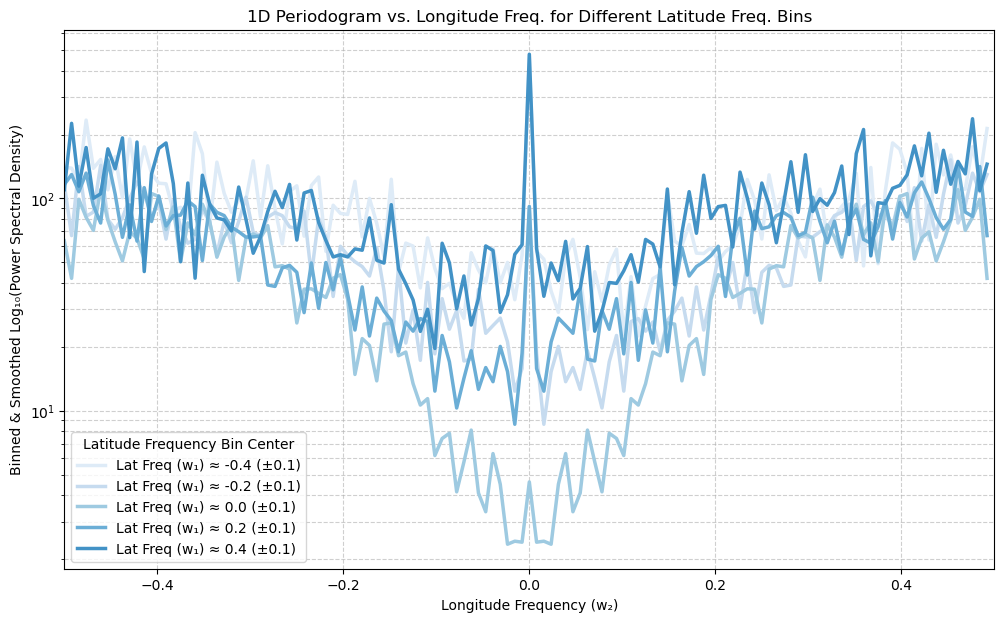

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq

def plot_binned_latitude_periodogram_custom_color(data_2d: np.ndarray):
    """
    Computes a 1D periodogram for longitude frequency by averaging the 2D PSD
    over several discrete latitude frequency bins, using a custom color scheme.

    This generates a single plot with 5 lines, each representing the spectrum
    averaged around a specific latitude frequency: -0.4, -0.2, 0, 0.2, and 0.4.

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N

    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}.")
        if N_TOTAL != 8192:
            raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")

    # --- DEMEANING STEP ---
    data_demeaned = data_2d - np.mean(data_2d)

    # --- 1. Compute 2D FFT and PSD ---
    fft_coeff = fftn(data_demeaned)
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    freq_lon = fftshift(fftfreq(N)) # X-axis for the plot
    freq_lat = fftshift(fftfreq(M)) # Used for binning

    # --- 3. Define Bins and Custom Colors for Plotting ---
    target_lat_freqs = [-0.4, -0.2, 0.0, 0.2, 0.4]
    tolerance = 0.1
    
    # **Use the custom blue colors you provided**
    # The plot will use the first 5 colors from this list.
    colors = [
        (222/255, 235/255, 247/255), # Lightest blue
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),  # Medium blue
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)     # Darkest blue
    ]

    plt.figure(figsize=(12, 7))

    for i, center_freq in enumerate(target_lat_freqs):
        min_freq = center_freq - tolerance
        max_freq = center_freq + tolerance
        
        lat_indices_mask = (freq_lat >= min_freq) & (freq_lat < max_freq)
        
        if not np.any(lat_indices_mask):
            print(f"Warning: No latitude frequencies found for bin centered at {center_freq}. Skipping.")
            continue
            
        psd_in_bin = psd_shifted[lat_indices_mask, :]
        psd_binned_1d = np.mean(psd_in_bin, axis=0)
        
        # Plot using the custom color list
        plt.semilogy(
            freq_lon, 
            psd_binned_1d, 
            color=colors[i], # Assigns a color from your list for each line
            linewidth=2.5,   # Slightly thicker line for better visibility
            label=f'Lat Freq (w₁) ≈ {center_freq:.1f} (±{tolerance})'
        )

    # --- 4. Finalize Plot ---
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Binned & Smoothed Log₁₀(Power Spectral Density)')
    plt.title('1D Periodogram vs. Longitude Freq. for Different Latitude Freq. Bins')
    plt.legend(title='Latitude Frequency Bin Center')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(-0.5, 0.5)
    plt.show()

# --- Example Usage ---
# This part remains the same as before.

M, N = 64, 128

try:
    unique_times = processed_df[0][:, 3].unique()
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new function
    plot_binned_latitude_periodogram_custom_color(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

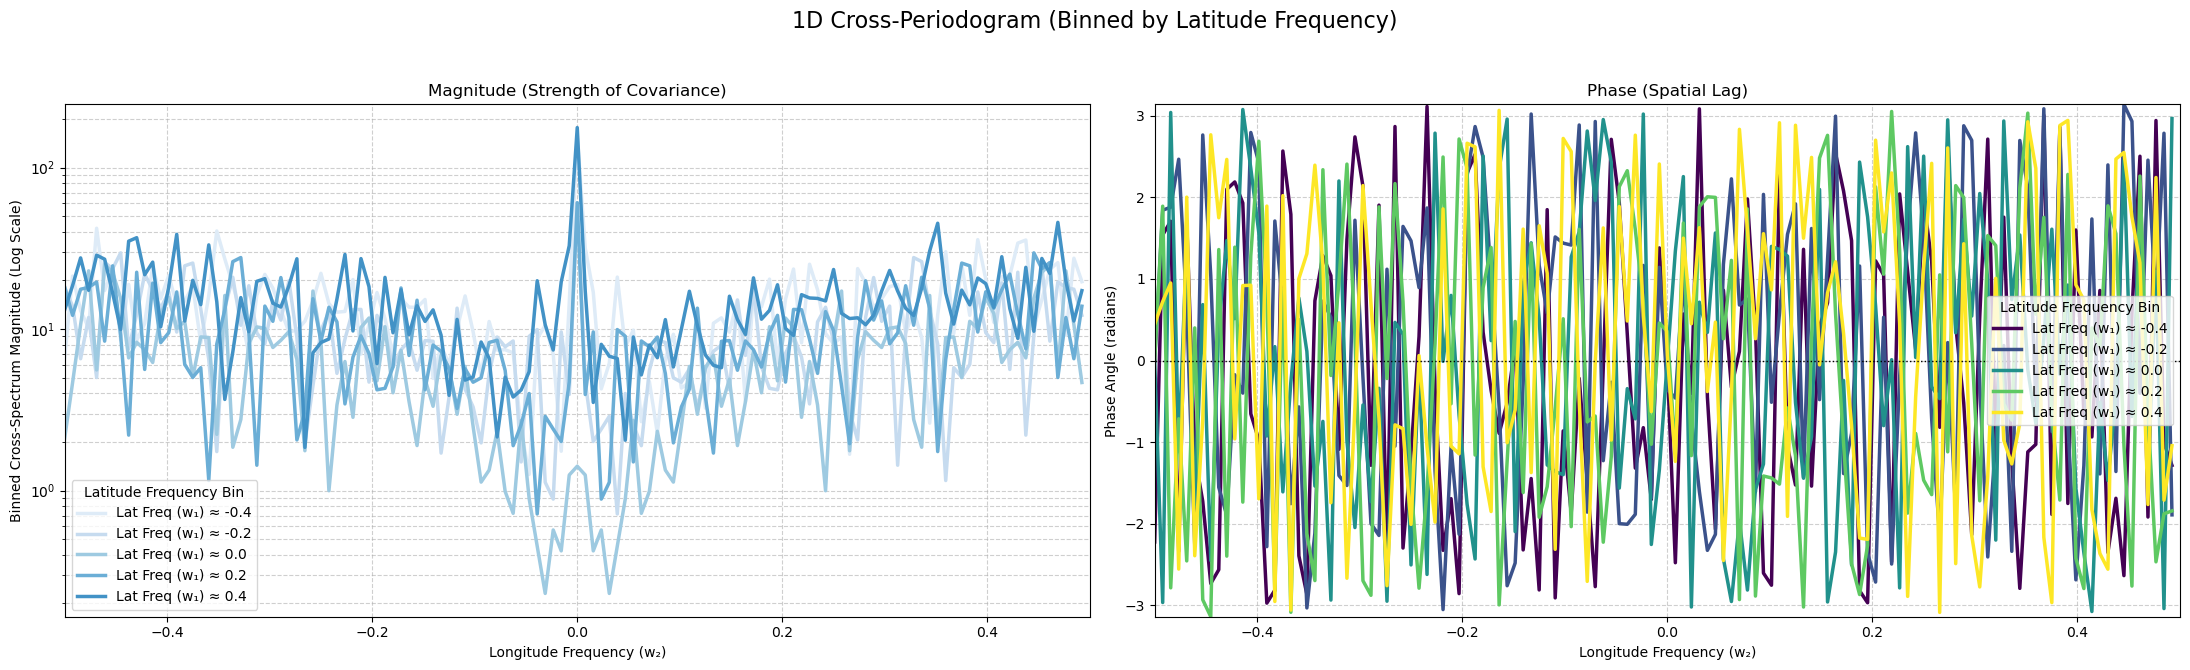

In [329]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq

def plot_binned_latitude_cross_periodogram(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Computes and plots a 1D cross-periodogram for longitude frequency,
    averaged over several discrete latitude frequency bins.

    This generates a two-panel plot:
    1. Magnitude: The strength of the covariance at each frequency.
    2. Phase: The spatial lag between the two datasets at each frequency.

    Args:
        data1_2d (np.ndarray): First 2D array of ozone values (e.g., hour 1).
        data2_2d (np.ndarray): Second 2D array of ozone values (e.g., hour 2).
    """
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # --- 1. Compute 2D FFT for BOTH datasets and find the Cross-Spectrum ---
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)

    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)

    # Cross-periodogram is FFT(d1) * conjugate(FFT(d2))
    cross_spec_shifted = fftshift((fft1 * np.conj(fft2)) / N_TOTAL)

    # --- 2. Generate Frequency Axes and Define Bins ---
    freq_lon = fftshift(fftfreq(N)) # X-axis for the plots
    freq_lat = fftshift(fftfreq(M)) # Used for binning
    target_lat_freqs = [-0.4, -0.2, 0.0, 0.2, 0.4]
    tolerance = 0.1
    
    # Colors for the magnitude plot
    mag_colors = [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255)
    ]
    # Colors for the phase plot
    phase_colors = plt.cm.viridis(np.linspace(0, 1, len(target_lat_freqs)))

    # --- 3. Setup Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(22, 7))
    fig.suptitle('1D Cross-Periodogram (Binned by Latitude Frequency)', fontsize=16)

    # --- 4. Loop Through Bins, Calculate, and Plot ---
    for i, center_freq in enumerate(target_lat_freqs):
        lat_indices_mask = (freq_lat >= (center_freq - tolerance)) & (freq_lat < (center_freq + tolerance))
        
        if not np.any(lat_indices_mask):
            continue
            
        # Average the complex cross-spectrum values within the bin
        cross_spec_in_bin = cross_spec_shifted[lat_indices_mask, :]
        cross_spec_binned_1d = np.mean(cross_spec_in_bin, axis=0)
        
        # Separate the averaged result into magnitude and phase
        magnitude_1d = np.abs(cross_spec_binned_1d)
        phase_1d = np.angle(cross_spec_binned_1d)
        
        # -- Plot Magnitude (Left) --
        label = f'Lat Freq (w₁) ≈ {center_freq:.1f}'
        axes[0].semilogy(freq_lon, magnitude_1d, color=mag_colors[i], linewidth=2.5, label=label)
        
        # -- Plot Phase (Right) --
        axes[1].plot(freq_lon, phase_1d, color=phase_colors[i], linewidth=2.5, label=label)

    # --- 5. Finalize Plots ---
    # Magnitude Plot
    axes[0].set_title('Magnitude (Strength of Covariance)')
    axes[0].set_xlabel('Longitude Frequency (w₂)')
    axes[0].set_ylabel('Binned Cross-Spectrum Magnitude (Log Scale)')
    axes[0].legend(title='Latitude Frequency Bin')
    axes[0].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[0].set_xlim(-0.5, 0.5)

    # Phase Plot
    axes[1].set_title('Phase (Spatial Lag)')
    axes[1].set_xlabel('Longitude Frequency (w₂)')
    axes[1].set_ylabel('Phase Angle (radians)')
    axes[1].axhline(0, color='black', linestyle=':', linewidth=1) # Add a line at zero phase
    axes[1].legend(title='Latitude Frequency Bin')
    axes[1].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[1].set_ylim(-np.pi, np.pi) # Set y-axis from -π to +π
    axes[1].set_xlim(-0.5, 0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Example Usage


M, N = 64, 128

hour = 1
try:
    unique_times = processed_df[0][:, 3].unique()
    
    # Get data for the first hour
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[hour]]
    ozone_signal_1 = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Get data for the second hour
    d1h2_slice = processed_df[0][processed_df[0][:, 3] == unique_times[hour+2]]
    ozone_signal_2 = d1h2_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new cross-periodogram function
    plot_binned_latitude_cross_periodogram(ozone_signal_1, ozone_signal_2)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
except IndexError:
    print("\nError: Could not find data for the second hour. Please check 'unique_times'.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

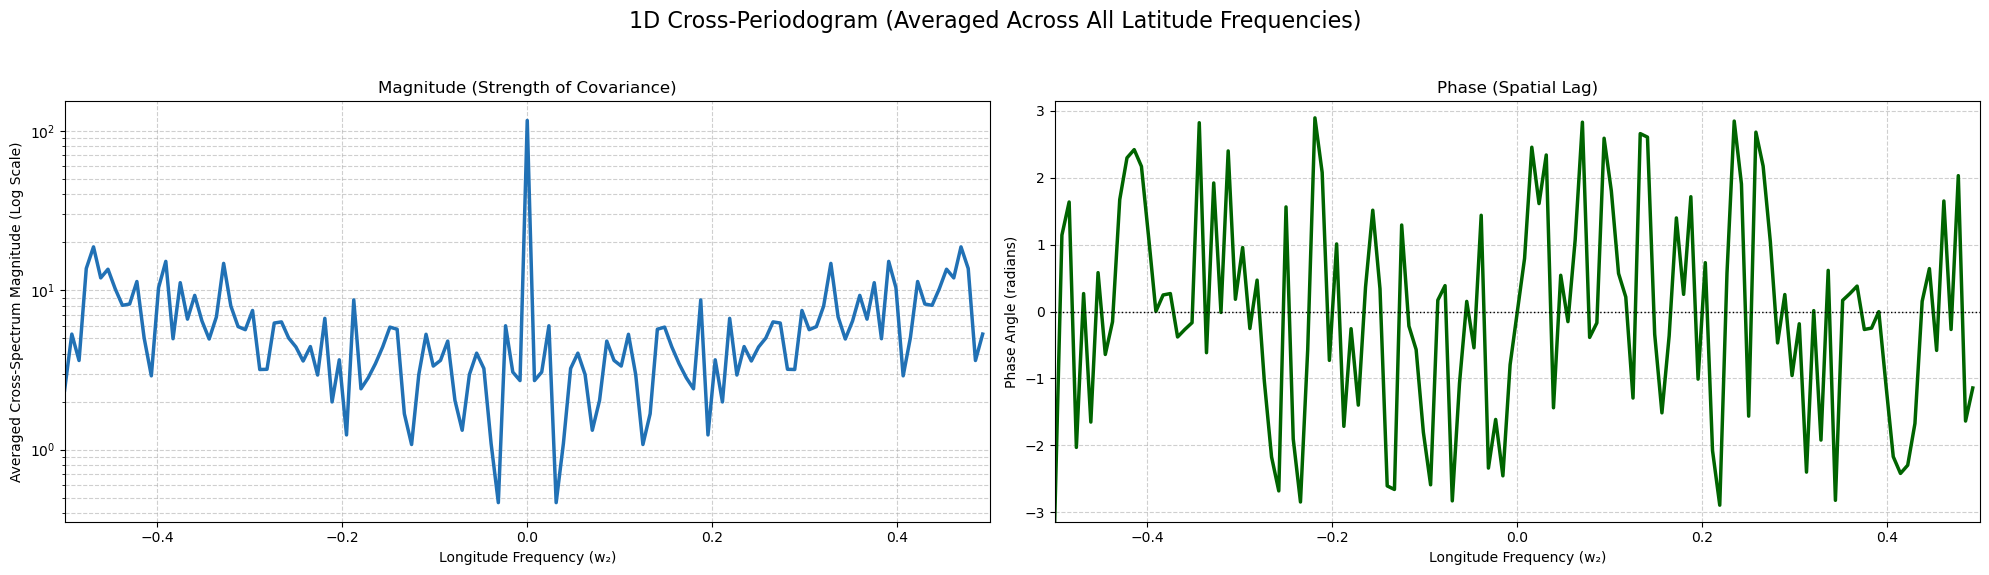

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq

def plot_global_latitude_cross_periodogram(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Computes and plots a 1D cross-periodogram for longitude frequency,
    averaged across ALL latitude frequencies.

    This generates a two-panel plot with a single line on each:
    1. Magnitude: The strength of the covariance.
    2. Phase: The spatial lag.

    Args:
        data1_2d (np.ndarray): First 2D array of ozone values (e.g., hour 1).
        data2_2d (np.ndarray): Second 2D array of ozone values (e.g., hour 2).
    """
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # --- 1. Compute 2D FFT and the Cross-Spectrum ---
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)

    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)

    cross_spec_shifted = fftshift((fft1 * np.conj(fft2)) / N_TOTAL)

    # --- 2. Average across all Latitude Frequencies ---
    # This replaces the binning loop by averaging across axis 0 (the latitude axis)
    cross_spec_avg_1d = np.mean(cross_spec_shifted, axis=0)
    
    # Separate the averaged result into magnitude and phase
    magnitude_1d = np.abs(cross_spec_avg_1d)
    phase_1d = np.angle(cross_spec_avg_1d)
        
    # --- 3. Generate Frequency Axis for Plotting ---
    freq_lon = fftshift(fftfreq(N)) # X-axis for the plots

    # --- 4. Setup and Create Plots ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle('1D Cross-Periodogram (Averaged Across All Latitude Frequencies)', fontsize=16)

    # -- Plot Magnitude (Left) --
    color_mag = (33/255, 113/255, 181/255) # A dark blue
    axes[0].semilogy(freq_lon, magnitude_1d, color=color_mag, linewidth=2.5)
    axes[0].set_title('Magnitude (Strength of Covariance)')
    axes[0].set_xlabel('Longitude Frequency (w₂)')
    axes[0].set_ylabel('Averaged Cross-Spectrum Magnitude (Log Scale)')
    axes[0].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[0].set_xlim(-0.5, 0.5)

    # -- Plot Phase (Right) --
    color_phase = 'darkgreen'
    axes[1].plot(freq_lon, phase_1d, color=color_phase, linewidth=2.5)
    axes[1].set_title('Phase (Spatial Lag)')
    axes[1].set_xlabel('Longitude Frequency (w₂)')
    axes[1].set_ylabel('Phase Angle (radians)')
    axes[1].axhline(0, color='black', linestyle=':', linewidth=1)
    axes[1].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[1].set_ylim(-np.pi, np.pi)
    axes[1].set_xlim(-0.5, 0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Example Usage
M, N = 64, 128

hour = 4
try:
    # Assuming 'processed_df' is already defined
    unique_times = processed_df[0][:, 3].unique()
    
    # Get data for the first hour
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[hour]]
    ozone_signal_1 = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Get data for the second hour
    d1h2_slice = processed_df[0][processed_df[0][:, 3] == unique_times[hour+1]]
    ozone_signal_2 = d1h2_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new cross-periodogram function
    plot_global_latitude_cross_periodogram(ozone_signal_1, ozone_signal_2)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
except IndexError:
    print("\nError: Could not find data for the second hour. Please check 'unique_times'.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

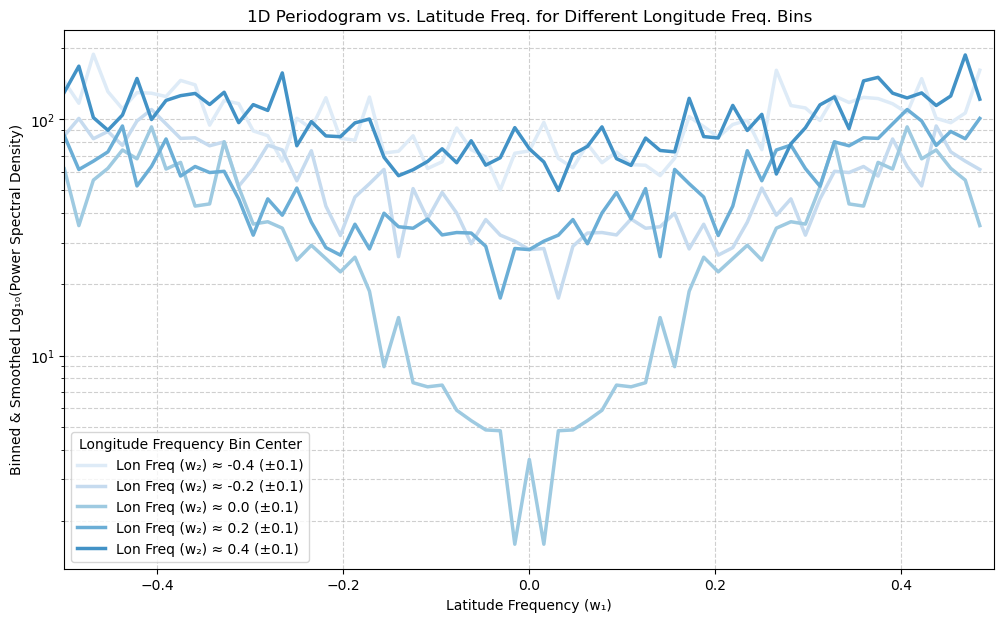

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq

def plot_binned_longitude_periodogram_custom_color(data_2d: np.ndarray):
    """
    Computes a 1D periodogram for latitude frequency by averaging the 2D PSD
    over several discrete longitude frequency bins, using a custom color scheme.

    This generates a single plot with 5 lines, each representing the spectrum
    averaged around a specific longitude frequency: -0.4, -0.2, 0, 0.2, and 0.4.

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N

    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}.")
        if N_TOTAL != 8192:
            raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")

    # --- DEMEANING STEP ---
    data_demeaned = data_2d - np.mean(data_2d)

    # --- 1. Compute 2D FFT and PSD ---
    fft_coeff = fftn(data_demeaned)
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    freq_lon = fftshift(fftfreq(N)) # Used for binning
    freq_lat = fftshift(fftfreq(M)) # X-axis for the plot

    # --- 3. Define Bins and Custom Colors for Plotting ---
    target_lon_freqs = [-0.4, -0.2, 0.0, 0.2, 0.4] # **Now binning by Longitude**
    tolerance = 0.1
    
    # Use the custom blue colors you provided
    colors = [
        (222/255, 235/255, 247/255), # Lightest blue
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),  # Medium blue
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)     # Darkest blue
    ]

    plt.figure(figsize=(12, 7))

    for i, center_freq in enumerate(target_lon_freqs):
        min_freq = center_freq - tolerance
        max_freq = center_freq + tolerance
        
        # **Create a mask for LONGITUDE frequencies (columns, axis 1)**
        lon_indices_mask = (freq_lon >= min_freq) & (freq_lon < max_freq)
        
        if not np.any(lon_indices_mask):
            print(f"Warning: No longitude frequencies found for bin centered at {center_freq}. Skipping.")
            continue
            
        # **Select the COLUMNS from the 2D PSD within the longitude bin**
        psd_in_bin = psd_shifted[:, lon_indices_mask]
        
        # **Average across the longitude dimension (axis 1) to get a 1D line**
        psd_binned_1d = np.mean(psd_in_bin, axis=1)
        
        # **Plot against LATITUDE frequency**
        plt.semilogy(
            freq_lat, 
            psd_binned_1d, 
            color=colors[i], 
            linewidth=2.5,
            label=f'Lon Freq (w₂) ≈ {center_freq:.1f} (±{tolerance})'
        )

    # --- 4. Finalize Plot (with updated labels) ---
    plt.xlabel('Latitude Frequency (w₁)')
    plt.ylabel('Binned & Smoothed Log₁₀(Power Spectral Density)')
    plt.title('1D Periodogram vs. Latitude Freq. for Different Longitude Freq. Bins')
    plt.legend(title='Longitude Frequency Bin Center')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(-0.5, 0.5)
    plt.show()

### Example Usage


M, N = 64, 128

try:
    unique_times = processed_df[0][:, 3].unique()
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)
    
    # Run the new swapped-axis function
    plot_binned_longitude_periodogram_custom_color(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

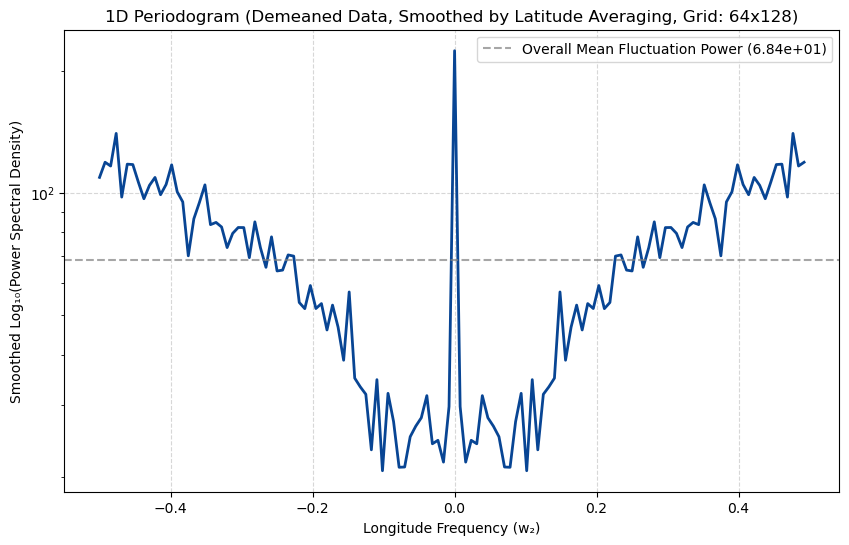

In [196]:
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_periodogram_contour(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    AFTER DEMEANING, and generates a 1D plot of Power vs. Longitude Frequency, 
    smoothed by averaging power across the Latitude Frequency axis.

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    
    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}. Plotting may be incorrect.")
        if N_TOTAL != 8192:
             raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")

    # --- DEMEANING STEP (CRUCIAL) ---
    # Subtract the overall mean to eliminate the DC spike at Freq=0.
    data_demeaned = data_2d - np.mean(data_2d)

    # --- 1. Compute 2D FFT and PSD ---
    # The FFT is now run on the zero-mean data.
    fft_coeff = fftn(data_demeaned)
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL
    psd_shifted = fftshift(psd_2d)

    # --- 2. SMOOTHING STEP: AVERAGE ACROSS LATITUDE FREQUENCY (AXIS 0) ---
    
    # Averaging the PSD across the Latitude axis (rows) collapses the 2D PSD to 1D.
    # The result has shape (N,) = (128,)
    psd_smoothed_1d = np.mean(psd_shifted, axis=0)
    
    # --- 3. Generate Frequency Axis for Longitude ---
    
    # Longitude Frequency (N=128) shifted to range [-0.5, 0.5]
    freq_lon = fftshift(fftfreq(N))

    # --- 4. Plotting (Line Plot for Smoothed 1D Spectrum) ---

    plt.figure(figsize=(10, 6))
    
    # Plotting smoothed PSD (Log scale for power is critical here)
    plt.semilogy(freq_lon, psd_smoothed_1d, color=(8/255, 69/255, 148/255), linewidth=2)
    
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Smoothed Log₁₀(Power Spectral Density)')
    plt.title(f'1D Periodogram (Demeaned Data, Smoothed by Latitude Averaging, Grid: {M}x{N})')
    
    # Add a horizontal line at the averaged mean power for white noise reference
    # Note: We calculate the mean power of the *demeaned* signal for reference here.
    mean_power = np.mean(psd_smoothed_1d)
    plt.axhline(y=mean_power, color='gray', linestyle='--', alpha=0.7, label=f'Overall Mean Fluctuation Power ({mean_power:.2e})')
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Example Usage (Using Actual 64x128 Ozone Data) ---

M, N = 64, 128
# Assuming processed_df is defined and available globally.

# NOTE: The previous error indicates that d1h1 contains 4 columns, leading to a size 32768.
# We must ensure only the ozone column is reshaped.
try:
    # 1. Select the unique time steps from the data
    unique_times = processed_df[0][:, 3].unique()
    # 2. Filter the data to get the first spatial slice (first hour data)
    d1h1_slice = processed_df[0][processed_df[0][:, 3] == unique_times[0]]

    # CRUCIAL: Select only the ozone column (index 2) and reshape into the M x N grid.
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)

    # Run the function
    plot_2d_periodogram_contour(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except IndexError:
    print("\nError: Data filtering failed. Check if processed_df[0] has time index in column 3.")


In [ ]:
def generate_
# Reshape the ozone data into a 2D NumPy grid
ozone_grid_2d = ozone_values.numpy().reshape(LAT_DIM, LON_DIM)

# Compute 2D DFT using the FFT algorithm
fft_coeff = fftn(ozone_grid_2d)

# Calculate Normalized Periodogram (PSD)
psd_2d_fft = np.abs(fft_coeff)**2 / GRID_SIZE

# Flatten in C-style order to match the loop indexing
psd_1d_fft = psd_2d_fft.flatten(order='C')

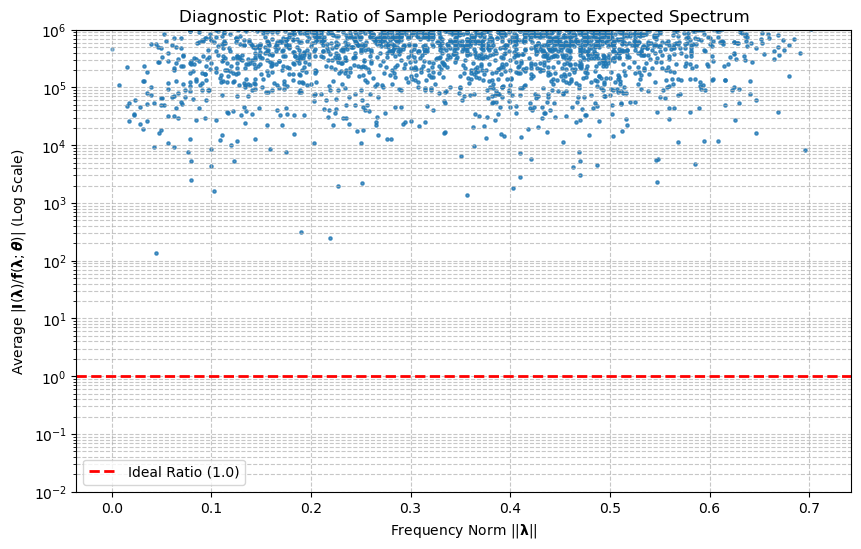

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift
import cmath

# --- Essential Functions (from previous context) ---

def cgn_hamming(u, n1, n2):
    u1, u2 = u
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1 / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2 / n2)
    return hamming1 * hamming2

def cov_x(u1, u2, t, params):
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    distance = (u1 / range_lat - advec_lat * t)**2 + (u2 / range_lon - advec_lon * t)**2 + (beta * t)**2
    return torch.where(distance != 0, sigmasq * torch.exp(-(distance)), sigmasq + nugget)

def cov_laplacian(u1, u2, t, params):
    delta1, delta2 = 0.044, 0.063
    stencil_weights = {(0, 0): -4, (0, 1): 1, (0, -1): 1, (1, 0): 1, (-1, 0): 1}
    cov = torch.zeros_like(u1, dtype=torch.float32)
    for (a, b), w_ab in stencil_weights.items():
        for (c, d), w_cd in stencil_weights.items():
            lag_x = (u1 + a - c) * delta1
            lag_y = (u2 + b - d) * delta2
            cov += w_ab * w_cd * cov_x(lag_x, lag_y, t, params)
    return cov

def cn_bar(u1, u2, t, params, n1, n2 , tampering_func):
    u = (u1, u2)
    return cov_laplacian(u1, u2, t, params) * tampering_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p,tampering_func):
    delta1, delta2 = 0.044, 0.063
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    
    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            product_tensor[:, :, q, r] = cn_bar(u1_mesh, u2_mesh, t, params, n1, n2,tampering_func)
            
    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = (delta1 * delta2) / (2 * cmath.pi)**2
    return fft_result * normalization_factor

def generate_Jvector(tensor_list, lat_col=0, lon_col=1, val_col=2):
    p = len(tensor_list)
    if p == 0: return torch.empty(0, 0, 0)
    fft_results = []
    
    unique_lats = torch.unique(tensor_list[0][:, lat_col])
    unique_lons = torch.unique(tensor_list[0][:, lon_col])
    n1, n2 = len(unique_lats), len(unique_lons)
    
    for tensor in tensor_list:
        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
        data_grid = torch.zeros((n1, n2), dtype=tensor.dtype)
        
        for row in tensor:
             # This lookup now works because coordinates are identical across all tensors
             i = lat_map[row[lat_col].item()]
             j = lon_map[row[lon_col].item()]
             data_grid[i, j] = row[val_col]

        fft_results.append(torch.fft.fft2(data_grid))
    
    J_vector_tensor = torch.stack(fft_results, dim=2)
    normalization_factor = 1.0 / (2 * cmath.pi) 
    return J_vector_tensor * normalization_factor

def calculate_sample_periodogram(J_vector_tensor):
    n1, n2, p = J_vector_tensor.shape
    I_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    for i in range(n1):
        for j in range(n2):
            J = J_vector_tensor[i, j, :].unsqueeze(1)
            I_tensor[i, j, :, :] = J @ J.T.conj()
    return I_tensor

def expected_periodogram_fft_shifted(params, n1, n2, p, tampering_func):
    f_raw = expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func)
    return torch.fft.fftshift(f_raw, dim=(-4, -3))


# =========================================================================
# 2. SETUP: DEFINE PARAMETERS AND CORRECT DATA INITIALIZATION
# =========================================================================

p = 6  
N1, N2 = 64, 128
best_params = torch.tensor([23.916, 5.546, 6.589, 1.100, -1.311, 1.516, 4.604], dtype=torch.float32)
TAMPERING_FUNC = cgn_hamming
delta1, delta2 = 0.044, 0.063

day = 1
cur_df = processed_df[day-1]  # Using the first day's processed tensor as an example
# Find unique time values
unique_times = torch.unique(cur_df[:, 3])
time_slices_list = []

for t_val in unique_times:
    time_slices_list.append(cur_df[cur_df[:, 3] == t_val])
tensor_list = time_slices_list[:1]  # Use the first p time slices


# --- EXECUTION AND PLOTTING LOGIC (as before) ---
J_vec = generate_Jvector(tensor_list, val_col=2)
I_shifted = torch.fft.fftshift(calculate_sample_periodogram(J_vec), dim=(-4, -3))
f_shifted = expected_periodogram_fft_shifted(best_params, N1, N2, p, TAMPERING_FUNC)
ratio_complex = I_shifted / f_shifted
diagonal_ratio = torch.diagonal(ratio_complex, dim1=2, dim2=3) 
ratio_magnitude_avg = torch.mean(torch.abs(diagonal_ratio), dim=2)
freq_lat, freq_lon = np.fft.fftfreq(N1), np.fft.fftfreq(N2)
freq_lon_shifted, freq_lat_shifted = fftshift(freq_lon), fftshift(freq_lat)
freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
norm_flat, ratio_flat = frequency_norm.flatten(), ratio_magnitude_avg.numpy().flatten()

# --- PLOTTING ---
plt.figure(figsize=(10, 6))
plt.scatter(norm_flat, ratio_flat, s=5, alpha=0.5)
plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal Ratio (1.0)')
plt.yscale('log')
plt.ylim(0.01, 1e6)
plt.title('Diagnostic Plot: Ratio of Sample Periodogram to Expected Spectrum')
plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
plt.ylabel(r'Average $|\mathbf{I}(\boldsymbol{\lambda}) / \mathbf{f}(\boldsymbol{\lambda}; \boldsymbol{\theta})|$ (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.savefig('periodogram_ratio_diagnostic_plot.png')

# Multivariate Debiased Whittle Likelihood

In [59]:
import numpy as np
import cmath
import pandas as pd
import time
import torch
import torch.nn.functional as F

def cgn(u, n1, n2):
    """
    Computes a 2D Bartlett window function (triangular window).
    
    Args:
        u (tuple): A tuple of lag indices (u1, u2) as torch.Tensors.
        n1 (int): The number of samples in the first dimension.
        n2 (int): The number of samples in the second dimension.
        
    Returns:
        torch.Tensor: The window value.
    """
    u1, u2 = u
    # Use torch operations for element-wise calculation
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2) 


def cgn_hamming(u, n1, n2):
    """
    Computes a 2D Hamming window.
    
    Args:
        u (tuple): A tuple of lag indices (u1, u2) as torch.Tensors.
        n1 (int): The number of samples in the first dimension.
        n2 (int): The number of samples in the second dimension.
        
    Returns:
        torch.Tensor: The window value.
    """
    u1, u2 = u
    # Calculate the 1D Hamming window for each dimension
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1 / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2 / n2)
    # The 2D window is the product of the 1D windows
    return hamming1 * hamming2

def cov_x(u1, u2, t, params):
    """
    Computes the spatio-temporal autocovariance of the original process.
    
    Args:
        u1 (torch.Tensor): The first spatial lag.
        u2 (torch.Tensor): The second spatial lag.
        t (torch.Tensor): The temporal lag.
        params (list): A list of parameters for the covariance function.
        
    Returns:
        torch.Tensor: The autocovariance value.
    """
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    distance = (u1 / range_lat - advec_lat * t)**2 + (u2 / range_lon - advec_lon * t)**2 + (beta * t)**2

    # Using torch.where for conditional logic on tensors
    # This avoids issues with distance == 0
    return torch.where(distance != 0, sigmasq * torch.exp(-(distance)), sigmasq + nugget)

def cov_laplacian(u1, u2, t, params):
    """
    Computes the autocovariance of the Laplacian-filtered process.
    
    Args:
        u1 (torch.Tensor): The first lag index.
        u2 (torch.Tensor): The second lag index.
        t (torch.Tensor): The temporal lag.
        params (list): A list of parameters for the covariance function.
        
    Returns:
        torch.Tensor: The autocovariance value of the filtered process.
    """
    delta1, delta2 = 0.044, 0.063
    
    # Define the 5-point stencil of the discrete Laplacian
    stencil_weights = {(0, 0): -4, (0, 1): 1, (0, -1): 1, (1, 0): 1, (-1, 0): 1}
    
    # Initialize cov as a tensor of the correct shape to handle broadcasting
    cov = torch.zeros_like(u1, dtype=torch.float32) # Ensure dtype matches
    # Iterate through all pairs of points in the stencil
    for (a, b), w_ab in stencil_weights.items():
        for (c, d), w_cd in stencil_weights.items():
            # Calculate the effective lag vector
            lag_x = (u1 + a - c) * delta1
            lag_y = (u2 + b - d) * delta2

            # Add the weighted covariance term
            cov += w_ab * w_cd * cov_x(lag_x, lag_y, t, params)
    return cov

def cn_bar(u1, u2, t, params, n1, n2 , tampering_func):
    """
    Computes the periodicized autocovariance by multiplying the
    Laplacian covariance with a 2D Bartlett window.
    
    Args:
        u1 (torch.Tensor): The first lag index.
        u2 (torch.Tensor): The second lag index.
        t (torch.Tensor): The temporal lag.
        params (list): Model parameters.
        n1 (int): The number of samples in the first dimension.
        n2 (int): The number of samples in the second dimension.
        
    Returns:
        torch.Tensor: The periodicized and windowed autocovariance value.
    """
    # u1 and u2 are now tensors
    u = (u1, u2)
    return cov_laplacian(u1, u2, t, params) * tampering_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p,tampering_func):
    """
    Computes the multivariate expected periodogram for ALL frequencies using a 2D FFT.
    This method is much faster than the direct summation.
    
    Args:
        params (list): Model parameters.
        n1 (int): The number of samples in the first spatial dimension.
        n2 (int): The number of samples in the second dimension.
        p (int): The number of multivariate components.
        
    Returns:
        torch.Tensor: A 4D tensor (n1, n2, p, p) of expected periodogram matrices.
    """
    delta1, delta2 = 0.044, 0.063
    
    # Create a 4D tensor to hold the term c_g,n * c_X
    # Shape will be (n1, n2, p, p)
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    
    # Define time lags based on the number of components
    t_lags = torch.arange(p, dtype=torch.float32)
    
    # Using torch.meshgrid to create tensors for u1 and u2 to enable vectorized operations
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    
    for q in range(p):
        for r in range(p):
            # Temporal lag
            t = t_lags[q] - t_lags[r]
            
            # Compute the windowed autocovariance product c_g,n * c_X
            # The formula in the paper is a sum over u, so we're building the term for each u
            product_tensor[:, :, q, r] = cn_bar(u1_mesh, u2_mesh, t, params, n1, n2,tampering_func)
            
    # Perform the 2D FFT on the spatial dimensions for each component pair
    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    # fft_result shape is (n1, n2, p, p)

    # Normalization factor from the paper
    normalization_factor = (delta1 * delta2) / (2 * cmath.pi)**2

    # delta 1 and delta 2 are dx1 dx2 in continuous integral. 
    
    expected_periodogram_tensor = fft_result * normalization_factor

    # Use torch.fft.fftshift
    return expected_periodogram_tensor


def generate_Jvector(tensor_list, lat_col=0, lon_col=1, val_col=2):
    """
    Generates a 3D tensor of DFT vectors from a list of tensors.
    
    Args:
        tensor_list (list): A list of tensors, where each tensor represents one
                            multivariate component.
        lat_col (int): Index of the latitude column.
        lon_col (int): Index of the longitude column.
        val_col (int): Index of the value column (e.g., 'laplacian').
        
    Returns:
        torch.Tensor: A 3D tensor (n1, n2, p) of DFT vectors for all frequencies.
    """
    p = len(tensor_list)
    if p == 0:
        return torch.empty(0, 0, 0)
        
    fft_results = []
    
    # Determine grid dimensions from the first tensor
    unique_lats = torch.unique(tensor_list[0][:, lat_col])
    unique_lons = torch.unique(tensor_list[0][:, lon_col])
    n1 = len(unique_lats)
    n2 = len(unique_lons)
    
    for tensor in tensor_list:
        # Create a grid from the flattened tensor
        # Map original lat/lon values to grid indices
        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}

        # Use the maps to get indices and reshape
        lat_indices = [lat_map[lat.item()] for lat in tensor[:, lat_col]]
        lon_indices = [lon_map[lon.item()] for lon in tensor[:, lon_col]]
        
        # Create the grid
        data_grid = torch.zeros((n1, n2), dtype=tensor.dtype)
        data_grid[lat_indices, lon_indices] = tensor[:, val_col]

        # Perform 2D FFT
        fft_results.append(torch.fft.fft2(data_grid))
    
    # Stack the 2D FFT results into a 3D tensor (n1, n2, p)
    J_vector_tensor = torch.stack(fft_results, dim=2)
    
    # Apply the normalization factor
    normalization_factor = 1.0 / (2 * cmath.pi)
    
    return J_vector_tensor * normalization_factor

def likelihood_vectorized(params, tensor_list,tampering_func):
    """
    Calculates the negative log-likelihood for the multivariate model
    using a vectorized approach for improved performance.
    
    Args:
        params (list): Model parameters.
        tensor_list (list): A list of tensors representing the multivariate data.
        
    Returns:
        torch.Tensor: The negative log-likelihood value.
    """
    p = len(tensor_list)
    if p == 0:
        return torch.tensor(0.0, dtype=torch.float32)
    
    # Determine dimensions from the first tensor
    unique_lats = torch.unique(tensor_list[0][:, 0])
    unique_lons = torch.unique(tensor_list[0][:, 1])
    n1 = len(unique_lats)
    n2 = len(unique_lons)
    n = n1 * n2

    # Compute the expected periodogram tensor from the model
    expected_periodogram = expected_periodogram_fft_multivariate(params, n1, n2, p,tampering_func)
    
    # Generate the J-vector tensor from the data
    j_vector = generate_Jvector(tensor_list)
    
    # Reshape tensors for batch processing
    I_omega_batch = expected_periodogram.reshape(-1, p, p)
    J_omega_batch = j_vector.reshape(-1, p, 1)

    # Add a small value to the real part of the diagonal for stability
    reg_term = torch.linalg.norm(I_omega_batch, dim=(1, 2), keepdim=True) * 1e-10 * torch.eye(p, dtype=I_omega_batch.dtype)
    I_omega_stable = torch.real(I_omega_batch) + reg_term
    
    # Compute the log-determinant of each matrix in the batch
    log_det = torch.log(torch.det(I_omega_stable)).real

    # Compute the inverse for each matrix in the batch
    inv_I_batch = torch.linalg.inv(I_omega_stable)
    
    # Compute the quadratic form: J^H * I^-1 * J
    term2_temp = torch.bmm(torch.conj(J_omega_batch.transpose(1, 2)), inv_I_batch)
    term2_batch = torch.bmm(term2_temp, J_omega_batch).reshape(-1)

    # The sum of log(det(I)) and the trace term over all frequencies
    nll_batch = log_det + term2_batch.real

    # Sum up all the log-likelihood terms
    nll = torch.sum(nll_batch)

    # Normalize the total negative log-likelihood
    return nll / n

# --- Example Usage with tensor_day1 ---

if __name__ == '__main__':
    # Assume tensor_day1 is your input tensor
    # To test the multivariate function, we'll split it into multiple time slices
    # Here, we'll create a list of 4 tensors, representing 4 time slices
    day = 1
    cur_df = processed_df[day-1]  # Using the first day's processed tensor as an example
    # Find unique time values
    unique_times = torch.unique(cur_df[:, 3])
    time_slices_list = []
    
    for t_val in unique_times:
        time_slices_list.append(cur_df[cur_df[:, 3] == t_val])

    print(f"Created a list of {len(time_slices_list)} tensors for multivariate test.")

    # Define some sample parameters
    params = torch.tensor([20.0, 1.0, 2.0, 0.01, 0.01, 0.01, 3], requires_grad=True)

# Calculate the negative log-likelihood
nll_value = likelihood_vectorized(params, time_slices_list, cgn_hamming)

print("\n--- Likelihood Calculation Complete ---")
print(f"Negative Log-Likelihood: {nll_value.item()}")



Created a list of 8 tensors for multivariate test.

--- Likelihood Calculation Complete ---
Negative Log-Likelihood: 21659780.0


In [60]:
from torch.optim.lr_scheduler import StepLR


# use adpating lr
def run_full(params, optimizer, scheduler,  covariance_function, epochs=10 ,tampering_func=cgn):
    
    """
    Run the training loop for the full likelihood model.

    Args:
        params (torch.Tensor): Model parameters.
        optimizer (torch.optim.Optimizer): Optimizer for updating parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        epochs (int): Number of epochs to train.

    Returns:
        list: Final parameters and loss.
        int: Number of epochs run.
    """

    prev_loss= float('inf')

    tol = 1e-3  # Convergence tolerance
    for epoch in range(epochs):  
        optimizer.zero_grad()  
        
        loss = likelihood_vectorized(params, time_slices_list,tampering_func)
        loss.backward()  # Backpropagate th e loss

        if epoch%50 == 0:
                # --- Check and print gradients and parameters at each iteration ---
            print(f'--- Epoch {epoch+1}/{epochs} ---')
            print(f' Loss: {loss.item()}')
            print(f' Parameters: {params.detach().numpy()}')
            print(f' Gradients: {params.grad}')
        
    
        # Check if loss is NaN or Inf, and break if it is
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping training.")
            print(f'Final Loss: {loss.item()}')
            print(f'Final Gradients: {params.grad}')
            break

        

        # Print gradients and parameters every 10th epoch
        #if epoch % 10 == 0:
        #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
        
        # if epoch % 500 == 0:
        #     print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
        
        optimizer.step()  
        scheduler.step()  
        # Check for convergence
        if abs(prev_loss - loss.item()) < tol:
            print(f"Converged at epoch {epoch}")
            print(f'Epoch {epoch+1}, : Loss: {loss.item()}, \n vecc Parameters: {params.detach().numpy()}')
            break

        prev_loss = loss.item()

    params = [torch.round(x*1000).detach().numpy()/1000 for x in params]
    loss = (torch.round(loss*1000)/1000).item()
    print(f'FINAL STATE: Epoch {epoch+1}, Loss: {loss}, \n vecc Parameters: {params}')
    return params + [loss], epoch

day = 5
cur_df = processed_df[day-1]  # Using the first day's processed tensor as an example
# Find unique time values
unique_times = torch.unique(cur_df[:, 3])
time_slices_list = []

for t_val in unique_times:
    time_slices_list.append(cur_df[cur_df[:, 3] == t_val])

# Convert the list of floats to a PyTorch tensor
params = torch.tensor([20.0, 3.0, 4.0, 0.004, -0.08, 0.01, 3.01], requires_grad=True)
lr, betas, eps, step_size, gamma = 0.01, (0.9, 0.99), 1e-08, 100, 0.8
optimizer = torch.optim.Adam([params], lr=lr, betas=betas, eps=eps)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  #

a,b = run_full( params, optimizer, scheduler, None, epochs=200 ,tampering_func=cgn_hamming)

--- Epoch 1/200 ---
 Loss: 25196934.0
 Parameters: [ 2.00e+01  3.00e+00  4.00e+00  4.00e-03 -8.00e-02  1.00e-02  3.01e+00]
 Gradients: tensor([-4.3750e-01,  2.2250e+01,  1.0250e+01,  1.4000e+01,  1.8500e+01,
        -2.1719e+00, -8.3711e+06])
--- Epoch 51/200 ---
 Loss: 21711454.0
 Parameters: [20.49459     2.4657772   3.4828434  -0.17563844 -0.02562637 -0.02489705
  3.4932108 ]
 Gradients: tensor([-1.6875e+00,  4.3250e+01,  1.3750e+01,  1.7000e+01,  1.2500e+01,
        -1.0938e+01, -6.2153e+06])
--- Epoch 101/200 ---
 Loss: 19304868.0
 Parameters: [ 2.1121084e+01  1.8237129e+00  2.8548648e+00 -1.9229139e-01
 -4.3371074e-02  1.0413129e-03  3.9286714e+00]
 Gradients: tensor([-4.3750e+00,  9.3250e+01,  2.7875e+01,  4.0000e+00, -6.2500e+00,
         5.2441e-01, -4.9138e+06])
--- Epoch 151/200 ---
 Loss: 17826902.0
 Parameters: [ 2.1711805e+01  1.1655997e+00  2.2885578e+00 -1.2897730e-01
  2.1390046e-01 -1.3468412e-04  4.2543316e+00]
 Gradients: tensor([-1.4094e+01,  8.4909e+02,  5.2875e+0

lr 0.01. step50 epoch 200

Loss: 22706554.000000
FINAL STATE: Epoch 200, Loss: 22706554.0, 
 vecc Parameters: [21.136, 0.79, 2.358, 0.122, -0.097, 0.0, 2.859]

 lr 0.01 step 100 epoch 600  smalll change after epoch 300

 --- Epoch 1/600 ---
 Loss: 32286718.0
 Gradients: tensor([-1.0500e+01,  2.5297e+02,  3.9000e+01, -1.0750e+01,  3.2000e+01,
        -1.4188e+01, -1.6063e+07])
--- Epoch 101/600 ---
 Loss: 22401716.0
 Gradients: tensor([-2.4288e+02,  3.1184e+04, -8.0125e+02, -2.1475e+02,  9.0000e+00,
        -9.9756e+00, -7.7329e+06])
--- Epoch 201/600 ---
 Loss: 17031722.0
 Gradients: tensor([ 2.6182e+05,  1.0712e+05, -1.9464e+06,  1.2475e+07,  1.0135e+08,
         8.4488e+06, -6.8022e+06])
--- Epoch 301/600 ---
 Loss: 16734517.0
 Gradients: tensor([ 3.2254e+05,  1.4013e+04, -4.5413e+05,  6.2497e+06,  2.3328e+07,
        -8.1825e+06, -6.9858e+06])
--- Epoch 401/600 ---
 Loss: 16704657.0
 Gradients: tensor([   249943.7500,     10871.4238,   -217640.0000,   7583911.0000,
           723587.0000, -10843837.0000,  -6504515.5000])
--- Epoch 501/600 ---
 Loss: 16663540.0
 Gradients: tensor([ 2.0924e+05,  9.9438e+03, -2.5152e+05,  7.5038e+06,  5.0710e+06,
        -1.1627e+07, -6.2263e+06])
FINAL STATE: Epoch 600, Loss: 16630042.0, 
 vecc Parameters: [21.645, -0.011, 3.064, -0.004, 0.007, 0.007, 3.407]

 lr 0.03 50 600

 --- Epoch 1/600 ---
 Loss: 32286718.0
 Gradients: tensor([-1.0500e+01,  2.5297e+02,  3.9000e+01, -1.0750e+01,  3.2000e+01,
        -1.4188e+01, -1.6063e+07])
--- Epoch 101/600 ---
 Loss: 17367230.0
 Gradients: tensor([    59566.8125, -20491166.0000,    -45886.5000, -17058900.0000,
         -2243651.7500,    468761.2500,  -5089638.0000])
--- Epoch 201/600 ---
 Loss: 16874694.0
 Gradients: tensor([   -8683.5625,  2789644.5000,   -95100.8750,  1474869.8750,
          567344.0000,   178033.7188, -4405246.0000])
--- Epoch 301/600 ---
 Loss: 16666024.0
 Gradients: tensor([   -7147.0938,  2270397.0000,   -86895.5000,   936746.6875,
          494532.1250,   173081.5625, -4305279.0000])
--- Epoch 401/600 ---
 Loss: 16588262.0
 Gradients: tensor([   -6682.1250,  2102722.5000,   -84959.6875,   796439.0000,
          478694.8750,   173921.0000, -4267694.5000])
--- Epoch 501/600 ---
 Loss: 16561779.0
 Gradients: tensor([   -6450.6562,  2013594.0000,   -84132.5000,   725261.8750,
          471525.3750,   174381.5938, -4255359.0000])
FINAL STATE: Epoch 600, Loss: 16553778.0, 
 vecc Parameters: [21.828, 0.184, 2.685, 0.073, 0.083, -0.104, 3.861]

In [24]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assume the functions likelihood_vectorized, cgn, cov_x, etc., 
# and the data `processed_df` are defined elsewhere in your script.

def run_full_revised(params_for_opt, positive_indices, optimizer, scheduler, epochs=400, tol=1e-6):
    """
    Run the revised training loop for the likelihood model.
    This version optimizes parameters in log-space to enforce positivity.

    Args:
        params_for_opt (torch.Tensor): Model parameters for optimization (some in log-space).
        positive_indices (list): Indices of parameters that must be positive.
        optimizer (torch.optim.Optimizer): The optimizer.
        scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
        epochs (int): Max number of epochs.
        tol (float): Relative tolerance for convergence.

    Returns:
        tuple: A tuple containing the final parameters, final loss, and epochs run.
    """
    prev_loss = float('inf')

    for epoch in range(epochs):
        optimizer.zero_grad()

        # NEW: Transform parameters from optimization-space back to model-space.
        # This ensures the parameters used in the likelihood are always positive.
        params_for_likelihood = params_for_opt.clone()
        params_for_likelihood[positive_indices] = torch.exp(params_for_opt[positive_indices])

        # Calculate the loss with the correctly scaled, positive parameters
        loss = likelihood_vectorized(params_for_likelihood, time_slices_list)

        # Stop if the loss becomes invalid
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping training.")
            break
        
        loss.backward()

        # Optional NEW: Gradient clipping can help if gradients still explode.
        # torch.nn.utils.clip_grad_norm_(params_for_opt, max_norm=1.0)

        optimizer.step()
        
        # NEW: Use the loss value to inform the scheduler
        scheduler.step(loss)

        # Print progress periodically
        if (epoch + 1) % 50 == 0:
            print(f'\n--- Epoch {epoch+1}/{epochs} ---')
            print(f'Loss: {loss.item():.2f}')
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')
            # Print the actual parameter values, not the log-space ones
            print(f'Parameters: {params_for_likelihood.detach().numpy()}')
            print(f'Gradients on Opt Params: {params_for_opt.grad}')

        # NEW: Check for convergence using relative tolerance
        if abs(prev_loss - loss.item()) / (abs(prev_loss) + 1e-8) < tol:
            print(f"\nConvergence tolerance met at epoch {epoch+1}.")
            break
        
        prev_loss = loss.item()

    # Final parameter values
    final_params = params_for_likelihood.detach()
    final_loss = loss.item()
    
    print(f'\n--- FINAL STATE ---')
    print(f'Finished at Epoch: {epoch+1}')
    print(f'Final Loss: {final_loss:.2f}')
    print(f'Final Parameters: {final_params.numpy()}')
    
    return final_params, final_loss, epoch + 1


if __name__ == '__main__':
    # --- 1. Data Preparation ---
    day = 5
    # Assuming processed_df is a list of tensors from your data loading
    cur_df = processed_df[day-1] 
    unique_times = torch.unique(cur_df[:, 3])
    time_slices_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]

    # --- 2. Parameter and Hyperparameter Setup ---
    # Initial guesses for the parameters
    initial_params = torch.tensor([20.0, 2.0, 3.0, 0.01, -0.001, 0.01, 2.01])

    # NEW: Define which parameters must be positive
    # Indices for: sigmasq, range_lat, range_lon, beta, nugget
    positive_indices = [0, 1, 2, 5, 6] 

    # NEW: Create the tensor for the optimizer. Positive params are converted to log-space.
    params_for_opt = initial_params.clone()
    # Add a small epsilon for stability in case an initial param is zero
    params_for_opt[positive_indices] = torch.log(initial_params[positive_indices] + 1e-8)
    params_for_opt.requires_grad = True

    # NEW: Revised hyperparameters for more stable training
    learning_rate = 0.01 # Lowered from 0.1
    
    # --- 3. Optimizer and Scheduler Setup ---
    optimizer = torch.optim.Adam([params_for_opt], lr=learning_rate)
    
    # NEW: Switched to a more adaptive scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',      # Reduce LR when the loss stops decreasing
        factor=0.5,      # New LR = LR * factor
        patience=25,     # Num of epochs with no improvement before reducing LR
        verbose=True     # Print a message when LR is updated
    )

    # --- 4. Run the Training ---
    print("--- Starting Revised Training ---")
    final_params, final_loss, epochs_run = run_full_revised(
        params_for_opt,
        positive_indices,
        optimizer,
        scheduler,
        epochs=500
    )

/opt/anaconda3/envs/faiss_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Starting Revised Training ---

--- Epoch 50/500 ---
Loss: 23742070.00
Learning Rate: 0.01
Parameters: [ 3.5220402e+01  1.1334873e+00  1.6887975e+00  1.2806693e-01
 -3.0661592e-01  7.9247933e-03  3.1899114e+00]
Gradients on Opt Params: tensor([-1.2129e+03,  3.1941e+03,  1.1484e+03,  9.7500e+00, -1.5000e+01,
         2.1125e-01, -2.3741e+07])

--- Epoch 100/500 ---
Loss: 16160026.00
Learning Rate: 0.01
Parameters: [ 8.9363510e+01  4.4858855e-01  6.5287918e-01  1.4978278e-01
 -6.4141959e-01  3.8112774e-03  4.6730866e+00]
Gradients on Opt Params: tensor([-4.5883e+04,  1.1528e+05,  6.8641e+04,  3.5725e+02, -1.7462e+03,
         8.6760e-01, -1.6114e+07])

--- Epoch 150/500 ---
Loss: 7393870.00
Learning Rate: 0.01
Parameters: [ 3.0684528e+02  1.3110958e-01  1.8935165e-01  8.4137663e-02
 -6.7186743e-01  1.7130258e-03  6.2448864e+00]
Gradients on Opt Params: tensor([-2.2103e+06,  4.5368e+06,  5.3449e+06, -2.7821e+04,  1.7029e+04,
        -2.1617e+00, -5.1836e+06])

--- Epoch 200/500 ---
Los

In [25]:
import torch
import torch.nn.functional as F

# --- Use one of your time slices from the list ---
# Assuming the first tensor in the list is representative
sample_tensor = time_slices_list[0] 

# --- Create the 2D grid of raw ozone values ---
# This code is similar to what's in your `generate_Jvector` function
unique_lats = torch.unique(sample_tensor[:, 0])
unique_lons = torch.unique(sample_tensor[:, 1])
n1, n2 = len(unique_lats), len(unique_lons)

# Map lat/lon to grid indices
lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
lat_indices = [lat_map[lat.item()] for lat in sample_tensor[:, 0]]
lon_indices = [lon_map[lon.item()] for lon in sample_tensor[:, 1]]

# Create the grid of raw values (assuming column 2 is the raw value before laplacian)
# If your 'laplacian' column is the only value you have, use that.
# But for this test, it's best to use the original, unfiltered values if available.
raw_grid = torch.zeros((n1, n2))
raw_grid[lat_indices, lon_indices] = sample_tensor[:, 2] # Use the 'value' column

# --- Apply the 5-point Laplacian Filter ---
# The stencil for the filter is [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Reshape grid for convolution
grid_batch = raw_grid.unsqueeze(0).unsqueeze(0)

# Apply convolution
filtered_grid = F.conv2d(grid_batch, laplacian_kernel, padding='same').squeeze()

# --- COMPARE THE VARIANCES ---
print(f"Variance of ORIGINAL data: {torch.var(raw_grid).item():.2f}")
print(f"Variance of FILTERED data: {torch.var(filtered_grid).item():.2f}")

Variance of ORIGINAL data: 52.08
Variance of FILTERED data: 1476.65


In [53]:
v05_base_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/estimates/df_cv_smooth_05/")


#full_day_r2s10_v045_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v045_spline1250.0.csv")
#full_day_r2s10_v055_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v055_spline1250.0.csv")

full_day_v05_r2s10_1127 = pd.read_csv(v05_base_path / "full_day_v05_r2s10_1127.csv")
vecchia_v05_r2s10_1127 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_1127.csv")
vecchia_v05_r2s10_4508 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_4508.csv")
vecchia_v05_r2s10_18033 = pd.read_csv( v05_base_path / "vecchia_v05_r2s10_18033.csv")

In [19]:
print(full_day_v05_r2s10_1127.head(8))

         day         cov_name  lat_lon_resolution    lr  stepsize   sigma  \
0  2024-07-1  full likelihood                1127  0.02       100  20.899   
1  2024-07-2  full likelihood                1127  0.02       100  21.489   
2  2024-07-3  full likelihood                1127  0.02       100  29.135   
3  2024-07-4  full likelihood                1127  0.02       100  26.559   
4  2024-07-5  full likelihood                1127  0.02       100  23.333   
5  2024-07-6  full likelihood                1127  0.02       100  19.829   
6  2024-07-7  full likelihood                1127  0.02       100  23.107   
7  2024-07-8  full likelihood                1127  0.02       100  20.907   

   range_lat  range_lon  advec_lat  advec_lon   beta  nugget       loss  \
0      1.040      1.337      0.040     -0.178  0.195   4.498  14625.690   
1      1.442      1.716     -0.016     -0.257  0.137   3.261  14196.832   
2      0.684      0.960     -0.039     -0.250  0.210   4.668  16045.347   
3     

In [13]:
from torch.optim.lr_scheduler import StepLR
# Convert the list of floats to a PyTorch tensor
params = torch.tensor([1.0, 1.0, 1.0, 0.01, 0.01, 0.01, 0.01], requires_grad=True)
lr, betas, eps, step_size, gamma = 0.1, (0.9, 0.99), 1e-08, 50, 0.5
optimizer = torch.optim.Adam([params], lr=lr, betas=betas, eps=eps)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  #

def run_full(params, optimizer, scheduler, likelihood_function, epochs=10):
    """
    Run the training loop for the full likelihood model.

    Args:
        params (torch.Tensor): Model parameters.
        optimizer (torch.optim.Optimizer): Optimizer for updating parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        likelihood_function (callable): The likelihood function to be optimized.
        epochs (int): Number of epochs to train.

    Returns:
        tuple: Final parameters and loss, and the number of epochs run.
    """
    prev_loss = float('inf')
    tol = 1e-3  # Convergence tolerance
    
    # Store history for plotting
    loss_history = []
    param_history = []
    grad_history = []

    for epoch in range(epochs):  
        optimizer.zero_grad()  
        
        # Calculate loss using the provided likelihood function
        loss = likelihood_function(params)
        loss.backward()  # Backpropagate the loss
        
        # --- Check and print gradients and parameters at each iteration ---
        print(f'--- Epoch {epoch+1}/{epochs} ---')
        
        # Check if loss is NaN or Inf, and break if it is
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping training.")
            print(f'Final Loss: {loss.item()}')
            print(f'Final Gradients: {params.grad}')
            print(f'Final Parameters: {params.detach()}')
            break

        print(f'Loss: {loss.item():.6f}')
        print(f'Parameters: {params.detach().numpy()}')
        if params.grad is not None:
            print(f'Gradients: {params.grad.numpy()}')
            
            # Check for NaN gradients
            if torch.isnan(params.grad).any() or torch.isinf(params.grad).any():
                print(f"Gradients became NaN or Inf at epoch {epoch+1}. Stopping training.")
                break
        else:
            print('Gradients: Not computed yet (first epoch).')
        print("-" * 30)

        # Update parameters
        optimizer.step()  
        scheduler.step()  
        
        # Check for convergence
        if abs(prev_loss - loss.item()) < tol:
            print(f"\nConverged at epoch {epoch+1}")
            print(f'Final State: Loss: {loss.item():.6f}, \n Parameters: {params.detach().numpy()}')
            break

        prev_loss = loss.item()

    # Final print and return
    final_loss = loss.item()
    final_params = params.detach().numpy()
    
    print(f'\nFINAL STATE: Epoch {epoch+1}, Loss: {final_loss:.6f}, \n Parameters: {final_params}')
    
    return final_params, final_loss, epoch

a,b,c = run_full( params, optimizer, scheduler, likelihood_vectorized, epochs= 50
    )

TypeError: likelihood_vectorized() missing 1 required positional argument: 'tensor_list'